# Images used in thesis

## Imports

In [1]:
import os

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imwrite, imread
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models

import sys
sys.path.append('code')
from eval_functions import calculate_score
from Loss_Metrics import jaccard_coef, jaccard_coef_loss, dice_coef_loss
from utils import prepare_test_dataset, tta
sys.path.append('../')

from eval_functions import calculate_score

## Display MapAI images

In [67]:
def display_dataset(path, data_name):
    
    # Find and display aerial image
    plt.figure(figsize=(5,5))
    aerial_img = cv.imread(os.path.normpath(path + '/image/' + data_name + '.PNG'))
    aerial_img = cv.cvtColor(aerial_img, cv.COLOR_BGR2RGB)
    plt.imshow(aerial_img)
    plt.axis('off')
    plt.show()
    
    # Find and display lidar image
    plt.figure(figsize=(5,5))
    lidar_img = np.load(os.path.normpath(path + '/lidar/' + data_name + '.npy'))
    plt.imshow(lidar_img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    # Find and display ground truth image
    plt.figure(figsize=(5,5))
    mask_img = cv.imread(os.path.normpath(path + '/mask/' + data_name + '.PNG'))
    plt.imshow(mask_img, cmap='gray')
    plt.axis('off')
    plt.show()

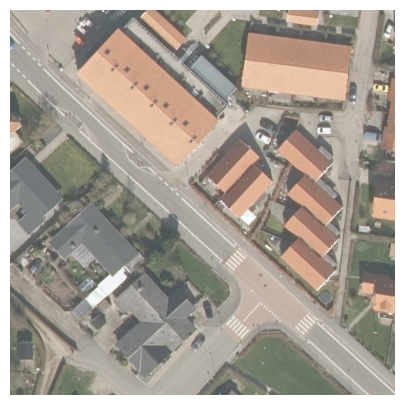

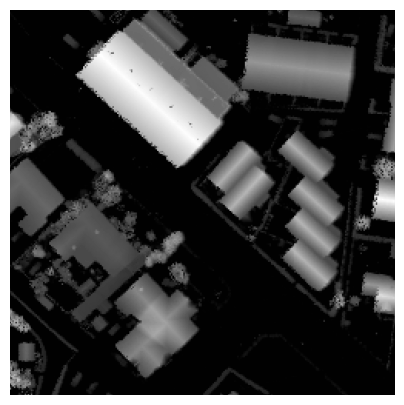

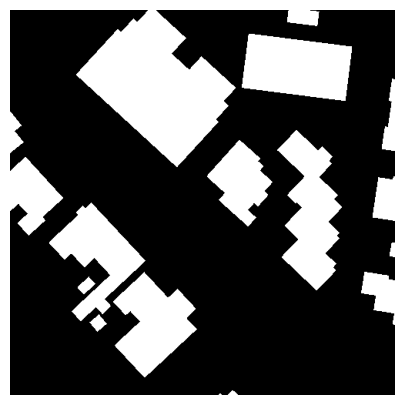

In [68]:
display_dataset(os.path.normpath('dataset/MapAI/train'), '6112_694_65')

## Display Preprocessed MapAI images

In [164]:
def display_dataset(path, data_name):
    
    # Find and display aerial image
    plt.figure(figsize=(5,5))
    aerial_img = cv.imread(os.path.normpath(path + '/image/train/' + data_name + '.PNG'))
    aerial_img = cv.cvtColor(aerial_img, cv.COLOR_BGR2RGB)
    plt.imshow(aerial_img)
    plt.axis('off')
    plt.show()
    
    # Find and display lidar image
    plt.figure(figsize=(5,5))
    lidar_img = imread(os.path.normpath(path + '/rgbLiDAR/train/' + data_name + '.tif'))
    plt.imshow(lidar_img[:, :, 3], cmap='gray')
    plt.axis('off')
    plt.show()
    
    # Find and display ground truth image
    plt.figure(figsize=(5,5))
    mask_img = cv.imread(os.path.normpath(path + '/mask/train/' + data_name + '.PNG'))
    mask_img[mask_img>0.5]=255
    plt.imshow(mask_img, cmap='gray')
    plt.axis('off')
    plt.show()

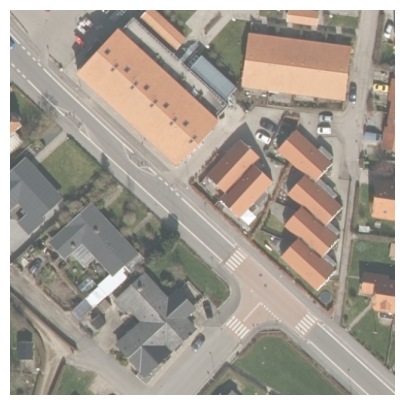

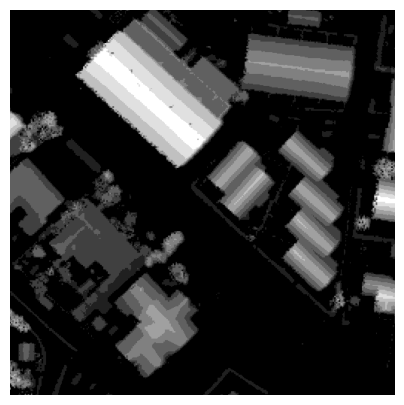

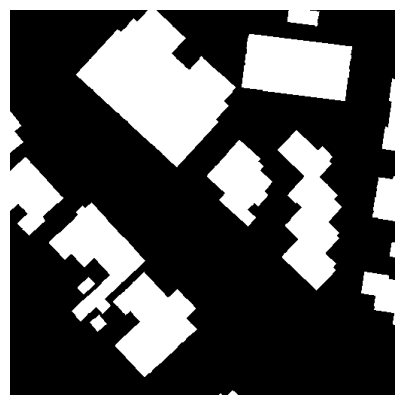

In [165]:
display_dataset(os.path.normpath('dataset/MapAI/preprocessed_train/'), '6112_694_65')

## Data Augmentation

In [87]:
train_set = 'rgbLiDAR'
color_mode = 'rgba'
mask = 'mask'
target_size=(512, 512)
seed = 420
batch_size = 6

# Setting augmentation args
img_data_gen_args = dict(rotation_range=90,
                         width_shift_range=0.3,
                         height_shift_range=0.3,
                         shear_range=0.5,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')
mask_data_gen_args = dict(rotation_range=90,
                          width_shift_range=0.3,
                          height_shift_range=0.3,
                          shear_range=0.5,
                          zoom_range=0.3,
                          horizontal_flip=True,
                          vertical_flip=True,
                          fill_mode='reflect',
                          preprocessing_function=lambda x: np.where(x > 0, 1, 0).astype(x.dtype)) # Binarize the output.

# Creating data generator for train and validation images and masks
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/preprocessed_train/' + train_set),
                                                           target_size=target_size,
                                                           seed=seed,
                                                           batch_size=batch_size,
                                                           color_mode=color_mode,
                                                           class_mode=None)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/preprocessed_train/' + mask),
                                                         target_size=target_size,
                                                         seed=seed,
                                                         batch_size=batch_size,
                                                         color_mode='grayscale',
                                                         class_mode=None)

train_generator = zip(image_generator, mask_generator)

Found 7000 images belonging to 1 classes.
Found 7000 images belonging to 1 classes.


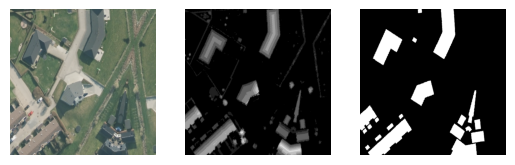

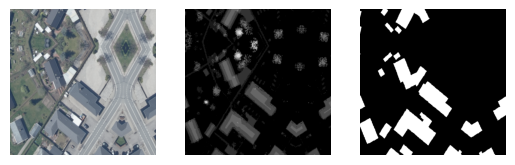

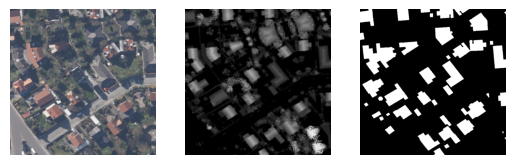

In [105]:
x, y = train_generator.__next__()

for i in range(0,3):
    image = x[i]
    aerial_img = cv.cvtColor(image[:, :, 0:3], cv.COLOR_BGR2RGB)
    mask = y[i]
    plt.subplot(1,3,1)
    plt.imshow(np.array(aerial_img[:, :, 0:3]).astype(np.uint))
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(image[:, :, 3],cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(mask*255, cmap='gray')
    plt.axis('off')
    plt.show()

In [169]:
train_set = 'rgbLiDAR'
color_mode = 'rgba'
mask = 'mask'
target_size=(512, 512)
seed = 420
batch_size = 1

# Setting augmentation args
img_data_gen_args = dict(rotation_range=90,
                         width_shift_range=0.3,
                         height_shift_range=0.3,
                         shear_range=0.5,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')
mask_data_gen_args = dict(rotation_range=90,
                          width_shift_range=0.3,
                          height_shift_range=0.3,
                          shear_range=0.5,
                          zoom_range=0.3,
                          horizontal_flip=True,
                          vertical_flip=True,
                          fill_mode='reflect',
                          preprocessing_function=lambda x: np.where(x > 0, 1, 0).astype(x.dtype)) # Binarize the output.

# Creating data generator for train and validation images and masks
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/aug_train/' + train_set),
                                                           target_size=target_size,
                                                           seed=seed,
                                                           batch_size=batch_size,
                                                           color_mode=color_mode,
                                                           class_mode=None)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/aug_train/' + mask),
                                                         target_size=target_size,
                                                         seed=seed,
                                                         batch_size=batch_size,
                                                         color_mode='grayscale',
                                                         class_mode=None)

train_generator = zip(image_generator, mask_generator)

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


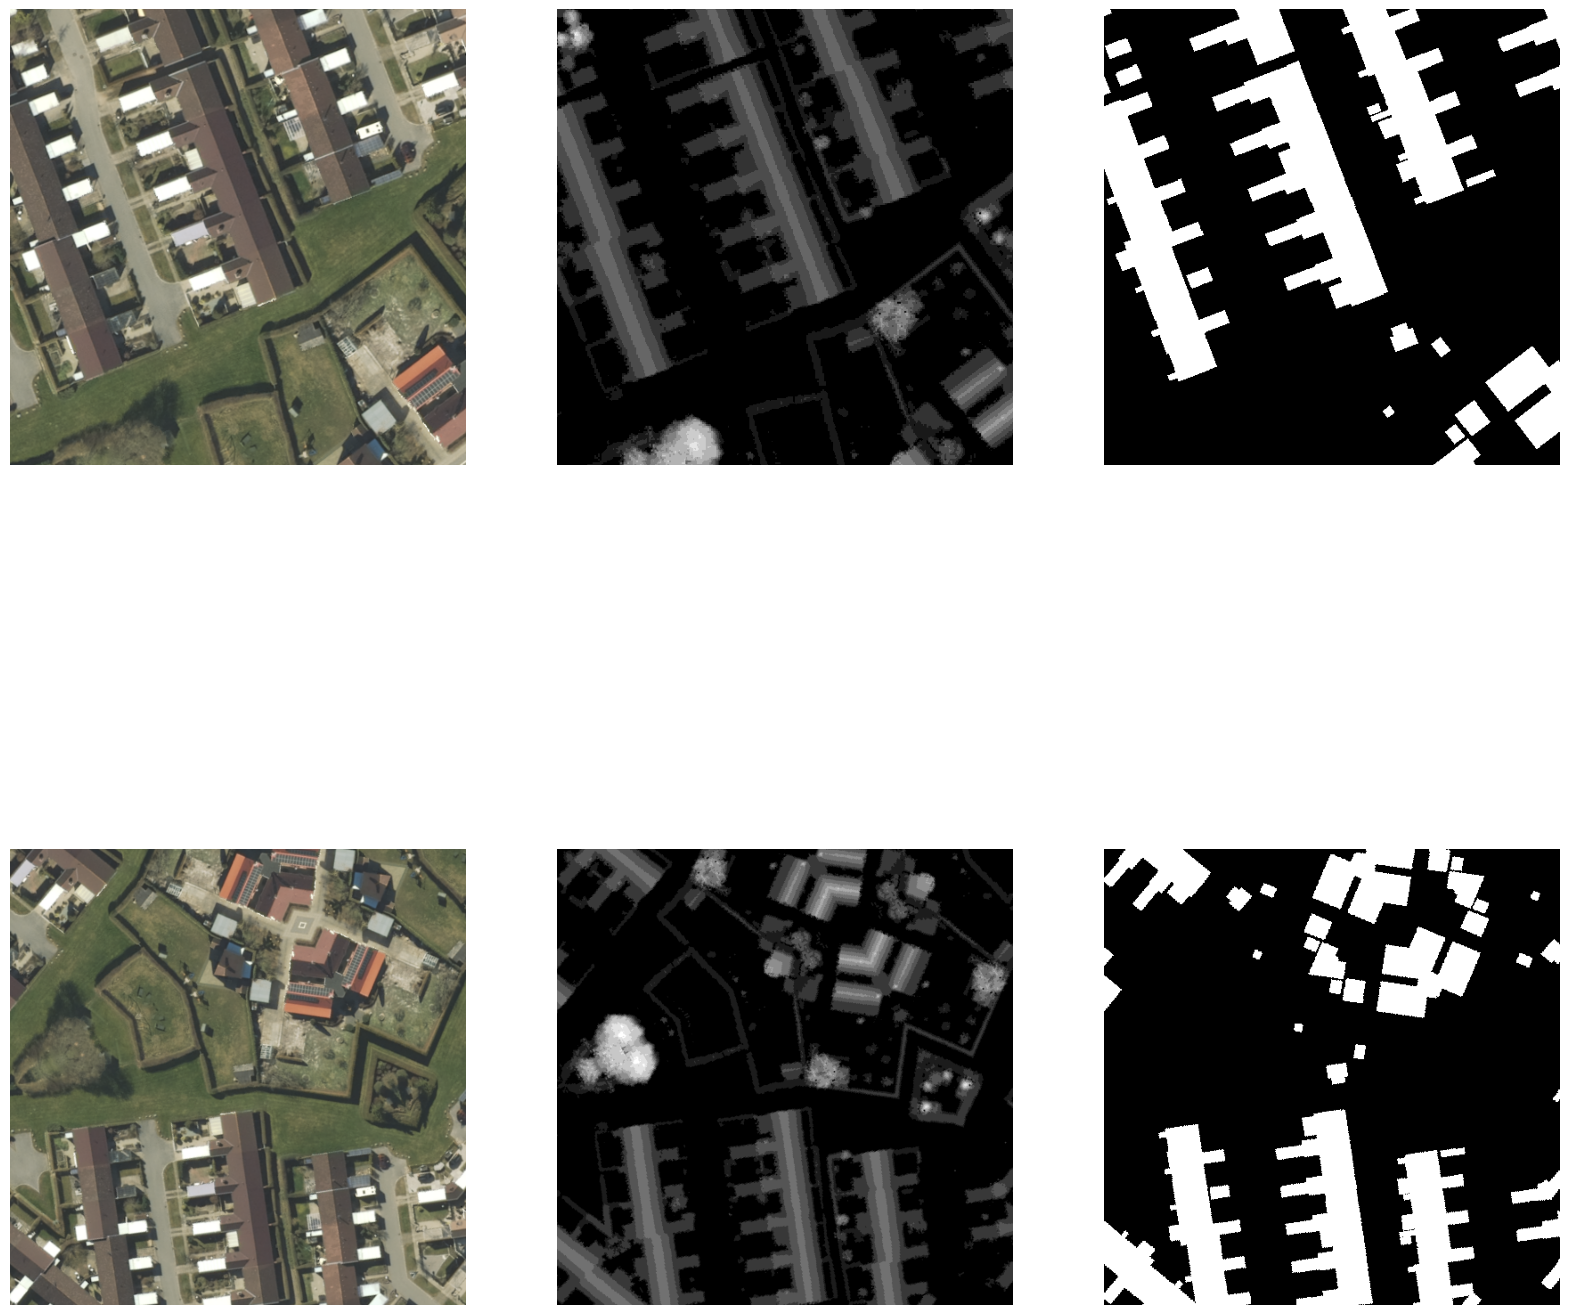

In [173]:
x, y = train_generator.__next__()

# Find and display aerial image
plt.figure(figsize=(20,20))
plt.subplot(2,3,1)
img = imread(os.path.normpath('dataset/MapAI/aug_train/rgbLiDAR/train/6104_604_77.tif'))
aerial_img = cv.cvtColor(img[:, :, 0:3], cv.COLOR_BGR2RGB)
plt.imshow(aerial_img)
plt.axis('off')

# Find and display lidar image
plt.subplot(2,3,2)
plt.imshow(img[:, :, 3], cmap='gray')
plt.axis('off')

# Find and display ground truth image
plt.subplot(2,3,3)
mask_img = cv.imread(os.path.normpath('dataset/MapAI/aug_train/mask/train/6104_604_77.png'))
plt.imshow(mask_img*255, cmap='gray')
plt.axis('off')

image = x[0]
aerial_img = cv.cvtColor(image[:, :, 0:3], cv.COLOR_BGR2RGB)
mask = y[0]
plt.subplot(2,3,4)
plt.imshow(np.array(aerial_img).astype(np.uint))
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(image[:, :, 3],cmap='gray')
plt.axis('off')
plt.subplot(2,3,6)
plt.imshow(mask*255, cmap='gray')
plt.axis('off')
plt.show()

## Predict Test Images

In [109]:
model_name = 'LiDAR_UNet_Baseline_Checkpoint.h5'
model = models.load_model(os.path.normpath('models/' + model_name), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})
Y_pred = model.predict(x)

C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\layers\core\lambda_layer.py:324: UserWarning: UNet is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


1/1 [==============================] - 19s 19s/step


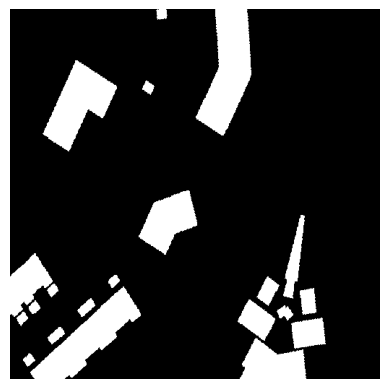

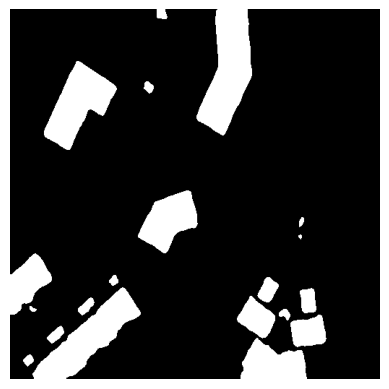

______________________________________________________


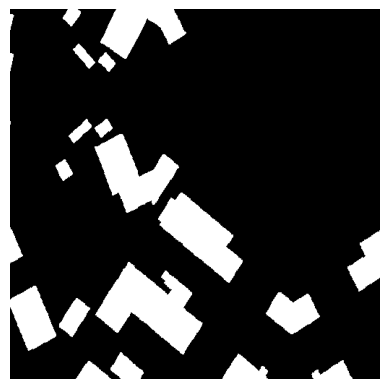

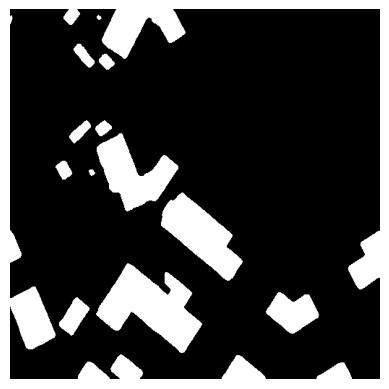

______________________________________________________


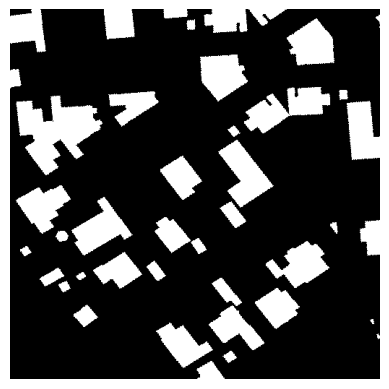

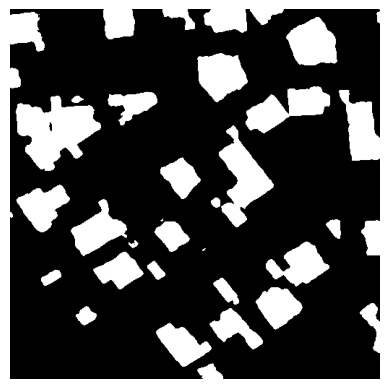

______________________________________________________


In [116]:
for i in range(0,3):
    mask = y[i]
    plt.imshow(mask,cmap='gray')
    plt.axis('off')
    plt.show()
    plt.imshow((Y_pred[i]>0.5),cmap='gray')
    plt.axis('off')
    plt.show()
    print('______________________________________________________')

## Predict Validation Images

In [119]:
train_set = 'rgbLiDAR'
color_mode = 'rgba'
mask = 'mask'
target_size=(512, 512)
seed = 420
batch_size = 6

val_data_generator = ImageDataGenerator()
valid_img_generator = val_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/preprocessed_validation/' + train_set),
                                                             target_size=target_size,
                                                             seed=seed,
                                                             batch_size=batch_size,
                                                             color_mode=color_mode,
                                                             class_mode=None)

valid_mask_generator = val_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/preprocessed_validation/' + mask),
                                                              target_size=target_size,
                                                              seed=seed,
                                                              batch_size=batch_size,
                                                              color_mode='grayscale',
                                                              class_mode=None)

val_generator = zip(image_generator, mask_generator)
x, y = val_generator.__next__()

model_name = 'LiDAR_UNet_Baseline_Checkpoint.h5'
model = models.load_model(os.path.normpath('models/' + model_name), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})
Y_pred = model.predict(x)

Found 1500 images belonging to 1 classes.
Found 1500 images belonging to 1 classes.
1/1 [==============================] - 20s 20s/step


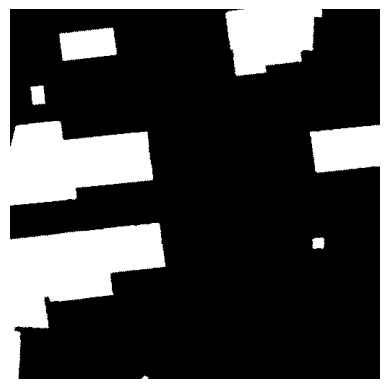

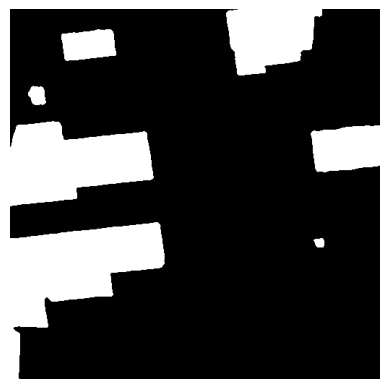

______________________________________________________


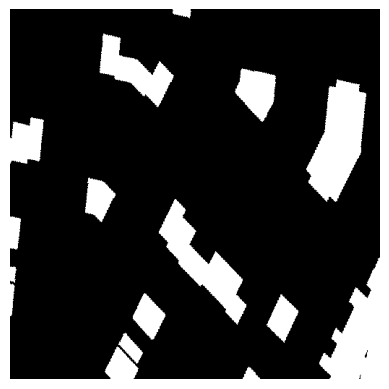

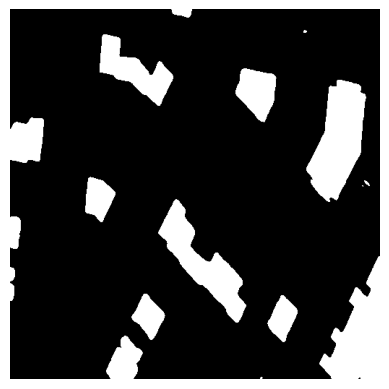

______________________________________________________


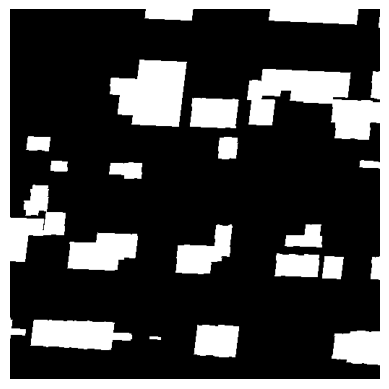

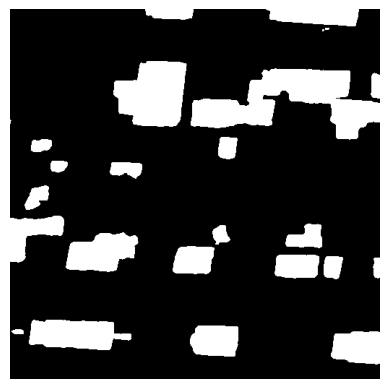

______________________________________________________


In [120]:
for i in range(0,3):
    mask = y[i]
    plt.imshow(mask,cmap='gray')
    plt.axis('off')
    plt.show()
    plt.imshow((Y_pred[i]>0.5),cmap='gray')
    plt.axis('off')
    plt.show()
    print('______________________________________________________')

## Predict Test Images

In [132]:
# Finding the number of images in each dataset
test_path = os.path.normpath('dataset/MapAI/preprocessed_task2_test/rgbLiDAR')
no_test_images = 11

# Defining size of images
IMG_HEIGHT = 512
IMG_WIDTH = 512

# Creating NumPy arrays for the different subsets
X_test = np.zeros((no_test_images, IMG_HEIGHT, IMG_WIDTH, 4), dtype=np.uint8)
Y_test = np.zeros((no_test_images, IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

# Adding images to NumPy arrays
img_path = os.path.normpath('dataset/MapAI/preprocessed_task2_test/rgbLiDAR')
mask_path = os.path.normpath('dataset/MapAI/preprocessed_task2_test/mask')

with os.scandir(img_path) as entries:
    for n, entry in enumerate(entries):
        filename = entry.name.split('.')
        img = imread(os.path.normpath(img_path + '/' + filename[0] + '.tif'))
        X_test[n] = img
        mask = cv.imread(os.path.normpath(mask_path + '/' + filename[0] + '.png'))
        mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
        Y_test[n] = mask
        if n == 10:
            break
        
print('X_train size: ' + str(len(X_test)))
print('Y_train size: ' + str(len(Y_test)))



X_train size: 11
Y_train size: 11


In [133]:
# Load model
model_name = 'LiDAR_UNet_Baseline_Checkpoint.h5'
model = models.load_model(os.path.normpath('models/' + model_name), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})
Y_pred = model.predict(X_test)

1/1 [==============================] - 36s 36s/step


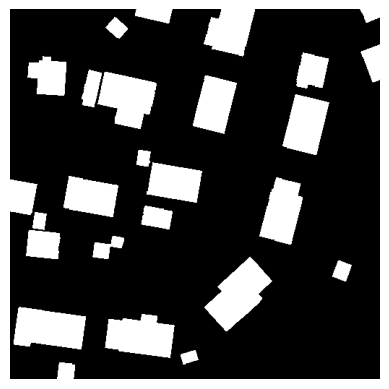

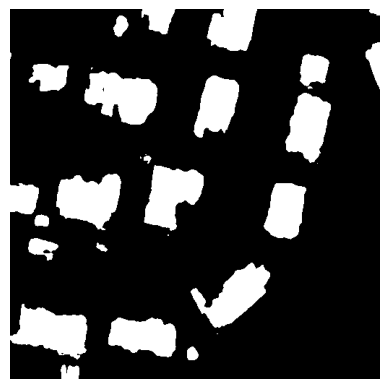

In [139]:
index = 6

plt.imshow(Y_test[index], cmap='gray')
plt.axis('off')
plt.show()
plt.imshow((Y_pred > 0.5)[index], cmap='gray')
plt.axis('off')
plt.show()

## Test Time Augmentation

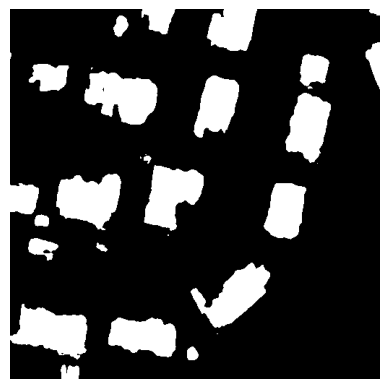

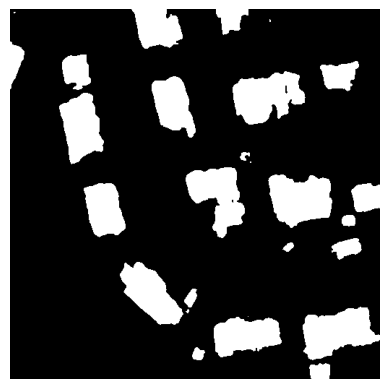

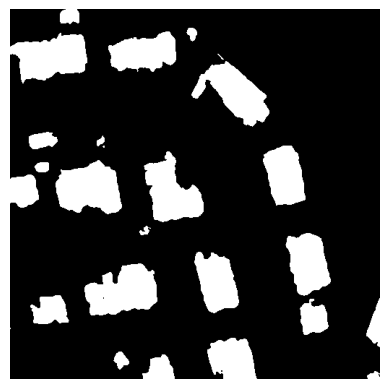

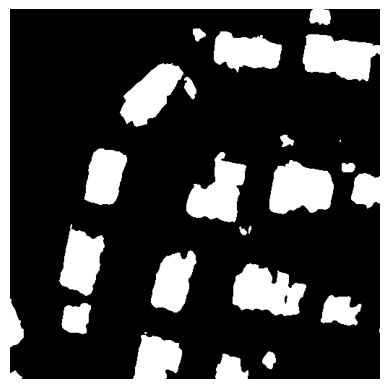

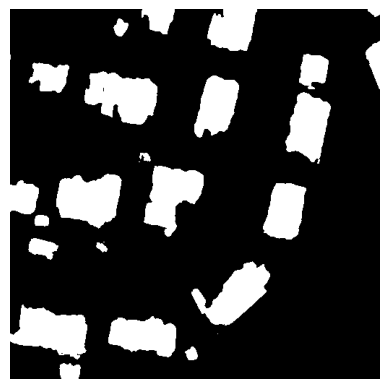

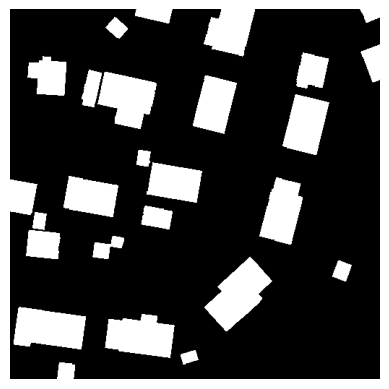

In [144]:
prediction_original = model.predict(np.expand_dims(X_test[6], axis=0), verbose=0)[0]
plt.imshow(prediction_original > 0.5, cmap='gray')
plt.axis('off')
plt.show()

prediction_lr = model.predict(np.expand_dims(np.fliplr(X_test[6]), axis=0), verbose=0)[0]
plt.imshow(prediction_lr > 0.5, cmap='gray')
plt.axis('off')
plt.show()
prediction_lr = np.fliplr(prediction_lr)

prediction_ud = model.predict(np.expand_dims(np.flipud(X_test[6]), axis=0), verbose=0)[0]
plt.imshow(prediction_ud > 0.5, cmap='gray')
plt.axis('off')
plt.show()
prediction_ud = np.flipud(prediction_ud)

prediction_lr_ud = model.predict(np.expand_dims(np.fliplr(np.flipud(X_test[6])), axis=0), verbose=0)[0]
plt.imshow(prediction_lr_ud > 0.5, cmap='gray')
plt.axis('off')
plt.show()
prediction_lr_ud = np.fliplr(np.flipud(prediction_lr_ud))

predicition = (prediction_original + prediction_lr + prediction_ud + prediction_lr_ud) / 4
plt.imshow(predicition > 0.3, cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(Y_test[6], cmap='gray')
plt.axis('off')
plt.show()

## Display original and preprocessed LiDAR data

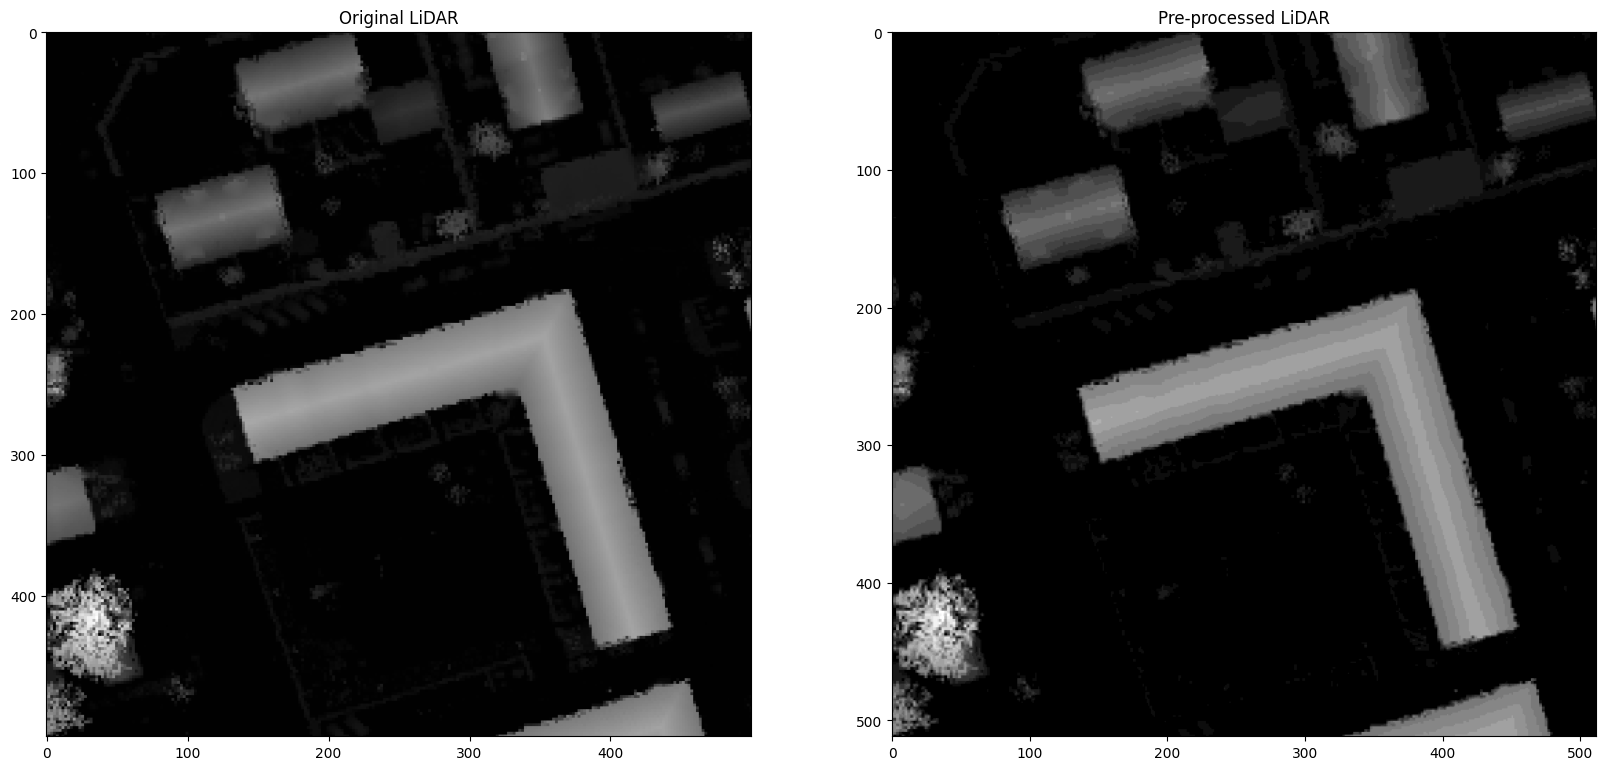

In [4]:
data_name = '6259_563_80'
path_new = os.path.normpath('dataset/MapAI/preprocessed_train')
path_original = os.path.normpath('dataset/MapAI/train')

plt.figure(figsize=(20,20))

lidar_data = np.load(os.path.normpath(path_original + '/lidar/' + data_name + '.npy'))
rgb_lidar = imread(os.path.normpath(path_new + '/rgbLiDAR/train/' + data_name + '.tif'))

plt.subplot(121)
plt.title('Original LiDAR')
plt.imshow(lidar_data, cmap='gray')

plt.subplot(122)
plt.title('Pre-processed LiDAR')
plt.imshow(rgb_lidar[:, :, 3], cmap='gray')
plt.show()


## Preliminary Tests U-Net

In [5]:
def export_logs(files_names, folder):
    prefix = 'logs'
    val_jaccard = {}
    val_loss = {}
    epoch = {}
    for file_name in files_names:
        val_jaccard[file_name] = []
        val_loss[file_name] = []
        epoch[file_name] = []
    
    for file_name in val_jaccard.keys():
        with open(os.path.normpath(prefix + '/' + folder + '/' + file_name)) as topo_file:
            for line in topo_file:
                csv = line.replace('\n', '').split(',')
                if csv[0] == 'epoch':
                    continue
                val_jaccard[file_name].append(float(csv[6]))
                val_loss[file_name].append(float(csv[7]))
                epoch[file_name].append(int(csv[0])+1)
    return val_jaccard, val_loss, epoch
    

### Batch Normalization Order

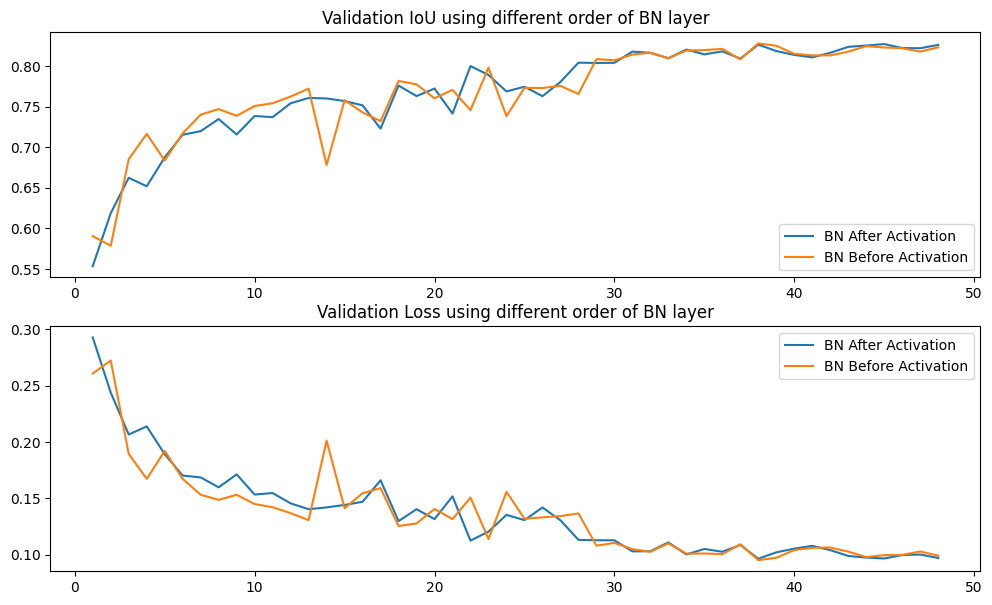

In [6]:
file_names = ['1_UNet_BN_After_log', '1_UNet_BN_Before_log']
val_jaccard, val_loss, epoch = export_logs(file_names, 'preliminary')
            
plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1)
plt.plot(epoch[file_names[0]], val_jaccard[file_names[0]], label='BN After Activation')
plt.plot(epoch[file_names[1]], val_jaccard[file_names[1]], label='BN Before Activation')
plt.legend(loc='lower right')
plt.title('Validation IoU using different order of BN layer')

plt.subplot(2, 1, 2)
plt.plot(epoch[file_names[0]], val_loss[file_names[0]], label='BN After Activation')
plt.plot(epoch[file_names[1]], val_loss[file_names[1]], label='BN Before Activation')
plt.legend(loc='upper right')
plt.title('Validation Loss using different order of BN layer')
plt.show()

### Initial LR

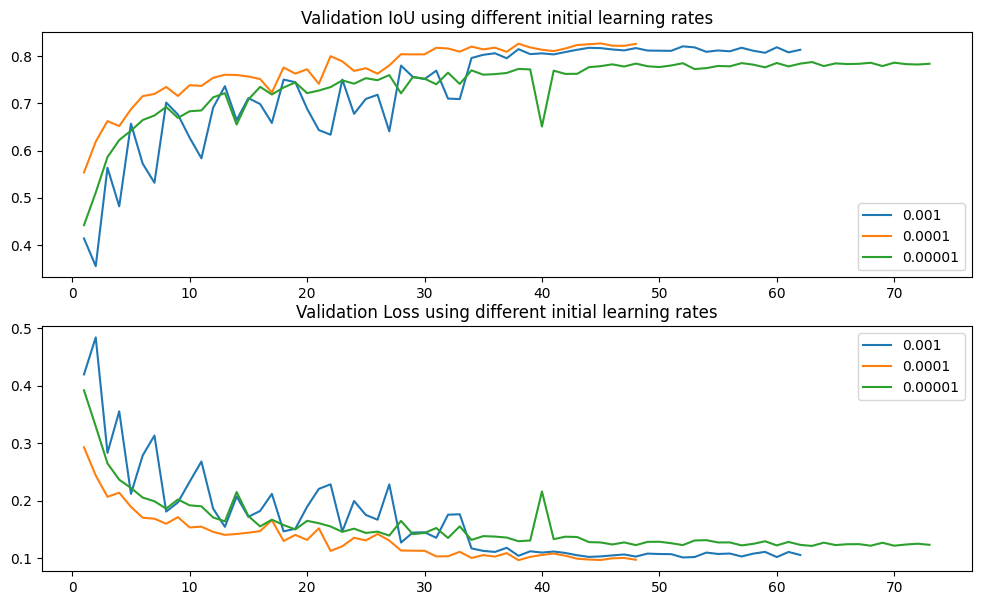

In [15]:
file_names = ['1_UNet_001_log', '1_UNet_BN_After_log', '1_UNet_00001_log']
val_jaccard, val_loss, epoch = export_logs(file_names, 'preliminary')
            
plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1)
plt.plot(epoch[file_names[0]], val_jaccard[file_names[0]], label='0.001')
plt.plot(epoch[file_names[1]], val_jaccard[file_names[1]], label='0.0001')
plt.plot(epoch[file_names[2]], val_jaccard[file_names[2]], label='0.00001')
plt.legend(loc='lower right')
plt.title('Validation IoU using different initial learning rates')

plt.subplot(2, 1, 2)
plt.plot(epoch[file_names[0]], val_loss[file_names[0]], label='0.001')
plt.plot(epoch[file_names[1]], val_loss[file_names[1]], label='0.0001')
plt.plot(epoch[file_names[2]], val_loss[file_names[2]], label='0.00001')
plt.legend(loc='upper right')
plt.title('Validation Loss using different initial learning rates')
plt.show()

### Loss Function

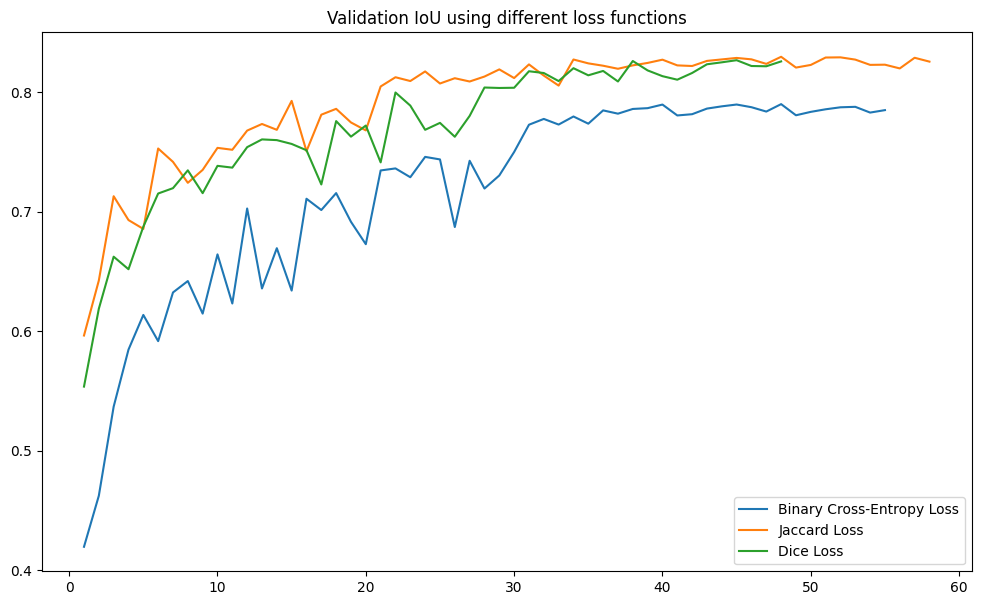

In [16]:
file_names = ['1_UNet_BCELoss_log', '1_UNet_JaccardLoss_log', '1_UNet_BN_After_log']
val_jaccard, val_loss, epoch = export_logs(file_names, 'preliminary')
            
plt.figure(figsize=(12, 7))
plt.plot(epoch[file_names[0]], val_jaccard[file_names[0]], label='Binary Cross-Entropy Loss')
plt.plot(epoch[file_names[1]], val_jaccard[file_names[1]], label='Jaccard Loss')
plt.plot(epoch[file_names[2]], val_jaccard[file_names[2]], label='Dice Loss')
plt.legend(loc='lower right')
plt.title('Validation IoU using different loss functions')
plt.show()


## Preliminary Tests CT-UNet

### Batch Normalization Order

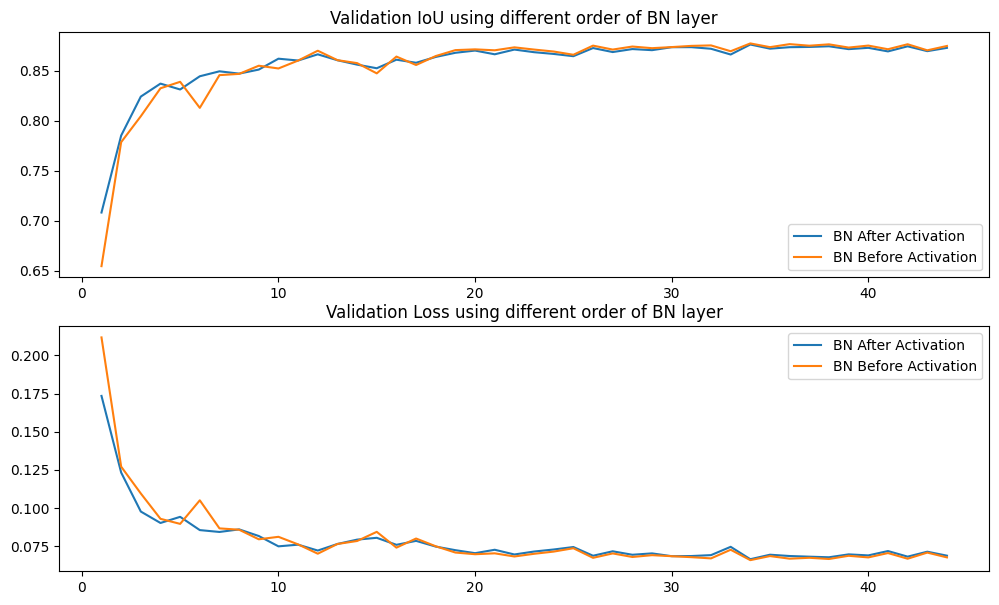

In [11]:
file_names = ['1_CTUNet_BN_After_log', '1_CTUNet_BN_Before_log']
val_jaccard, val_loss, epoch = export_logs(file_names, 'preliminary')

plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1)
plt.plot(epoch[file_names[0]], val_jaccard[file_names[0]], label='BN After Activation')
plt.plot(epoch[file_names[1]], val_jaccard[file_names[1]], label='BN Before Activation')
plt.legend(loc='lower right')
plt.title('Validation IoU using different order of BN layer')

plt.subplot(2, 1, 2)
plt.plot(epoch[file_names[0]], val_loss[file_names[0]], label='BN After Activation')
plt.plot(epoch[file_names[1]], val_loss[file_names[1]], label='BN Before Activation')
plt.legend(loc='upper right')
plt.title('Validation Loss using different order of BN layer')
plt.show()

### Initial LR

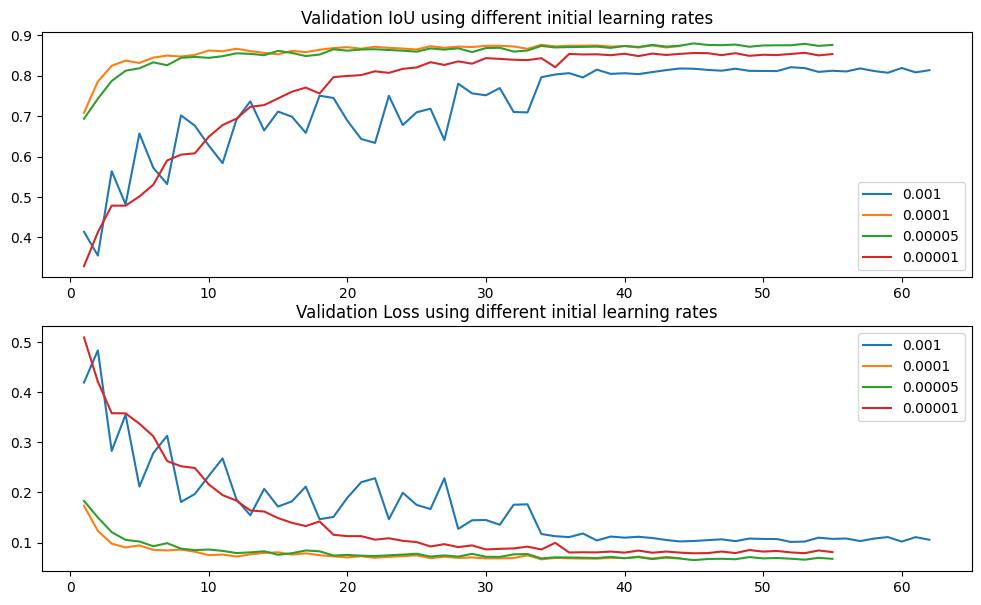

In [13]:
file_names = ['1_UNet_001_log', '1_CTUNet_BN_After_log', '1_CTUNet_00005_log', '1_CTUNet_00001_log']
val_jaccard, val_loss, epoch = export_logs(file_names, 'preliminary')
            
plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1)
plt.plot(epoch[file_names[0]], val_jaccard[file_names[0]], label='0.001')
plt.plot(epoch[file_names[1]], val_jaccard[file_names[1]], label='0.0001')
plt.plot(epoch[file_names[2]], val_jaccard[file_names[2]], label='0.00005')
plt.plot(epoch[file_names[3]], val_jaccard[file_names[3]], label='0.00001')
plt.legend(loc='lower right')
plt.title('Validation IoU using different initial learning rates')

plt.subplot(2, 1, 2)
plt.plot(epoch[file_names[0]], val_loss[file_names[0]], label='0.001')
plt.plot(epoch[file_names[1]], val_loss[file_names[1]], label='0.0001')
plt.plot(epoch[file_names[2]], val_loss[file_names[2]], label='0.00005')
plt.plot(epoch[file_names[3]], val_loss[file_names[3]], label='0.00001')
plt.legend(loc='upper right')
plt.title('Validation Loss using different initial learning rates')
plt.show()

### Loss Function

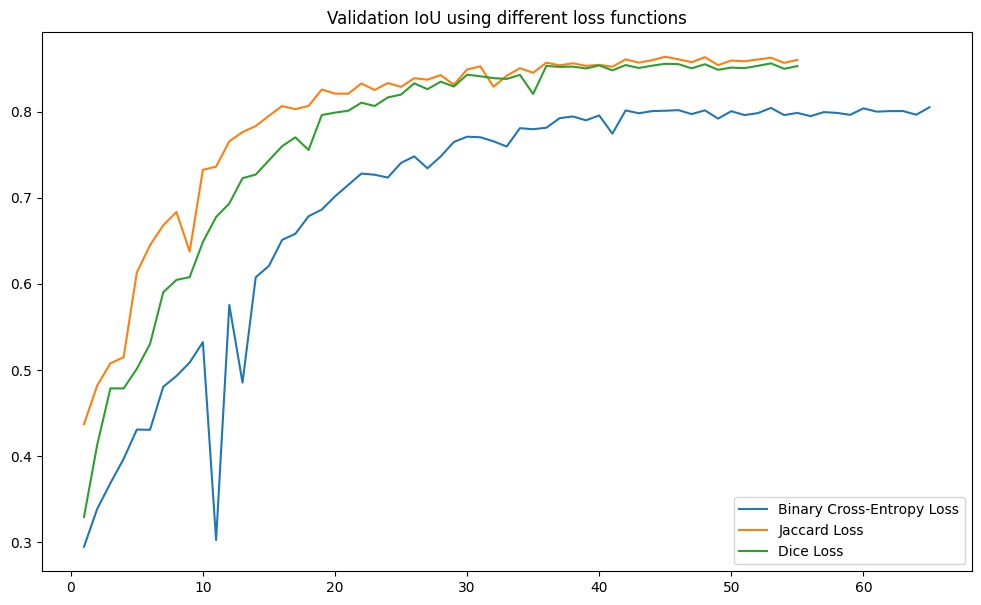

In [18]:
file_names = ['1_CTUNet_BCELoss_log', '1_CTUNet_JaccardLoss_log', '1_CTUNet_00001_log']
val_jaccard, val_loss, epoch = export_logs(file_names, 'preliminary')
            
plt.figure(figsize=(12, 7))
plt.plot(epoch[file_names[0]], val_jaccard[file_names[0]], label='Binary Cross-Entropy Loss')
plt.plot(epoch[file_names[1]], val_jaccard[file_names[1]], label='Jaccard Loss')
plt.plot(epoch[file_names[2]], val_jaccard[file_names[2]], label='Dice Loss')
plt.legend(loc='lower right')
plt.title('Validation IoU using different loss functions')
plt.show()

## Task 1 Training

In [5]:
def export_logs_train(files_names):
    prefix = 'logs'
    train_jaccard = {}
    val_jaccard = {}
    epoch = {}
    for file_name in files_names:
        train_jaccard[file_name] = []
        val_jaccard[file_name] = []
        epoch[file_name] = []
    
    for file_name in val_jaccard.keys():
        with open(os.path.normpath(prefix + '/' + file_name)) as topo_file:
            for line in topo_file:
                csv = line.replace('\n', '').split(',')
                if csv[0] == 'epoch':
                    continue
                train_jaccard[file_name].append(float(csv[2]))
                val_jaccard[file_name].append(float(csv[6]))
                epoch[file_name].append(int(csv[0])+1)
    return train_jaccard, val_jaccard, epoch

sns.set_style("whitegrid", {'axes.grid' : True})

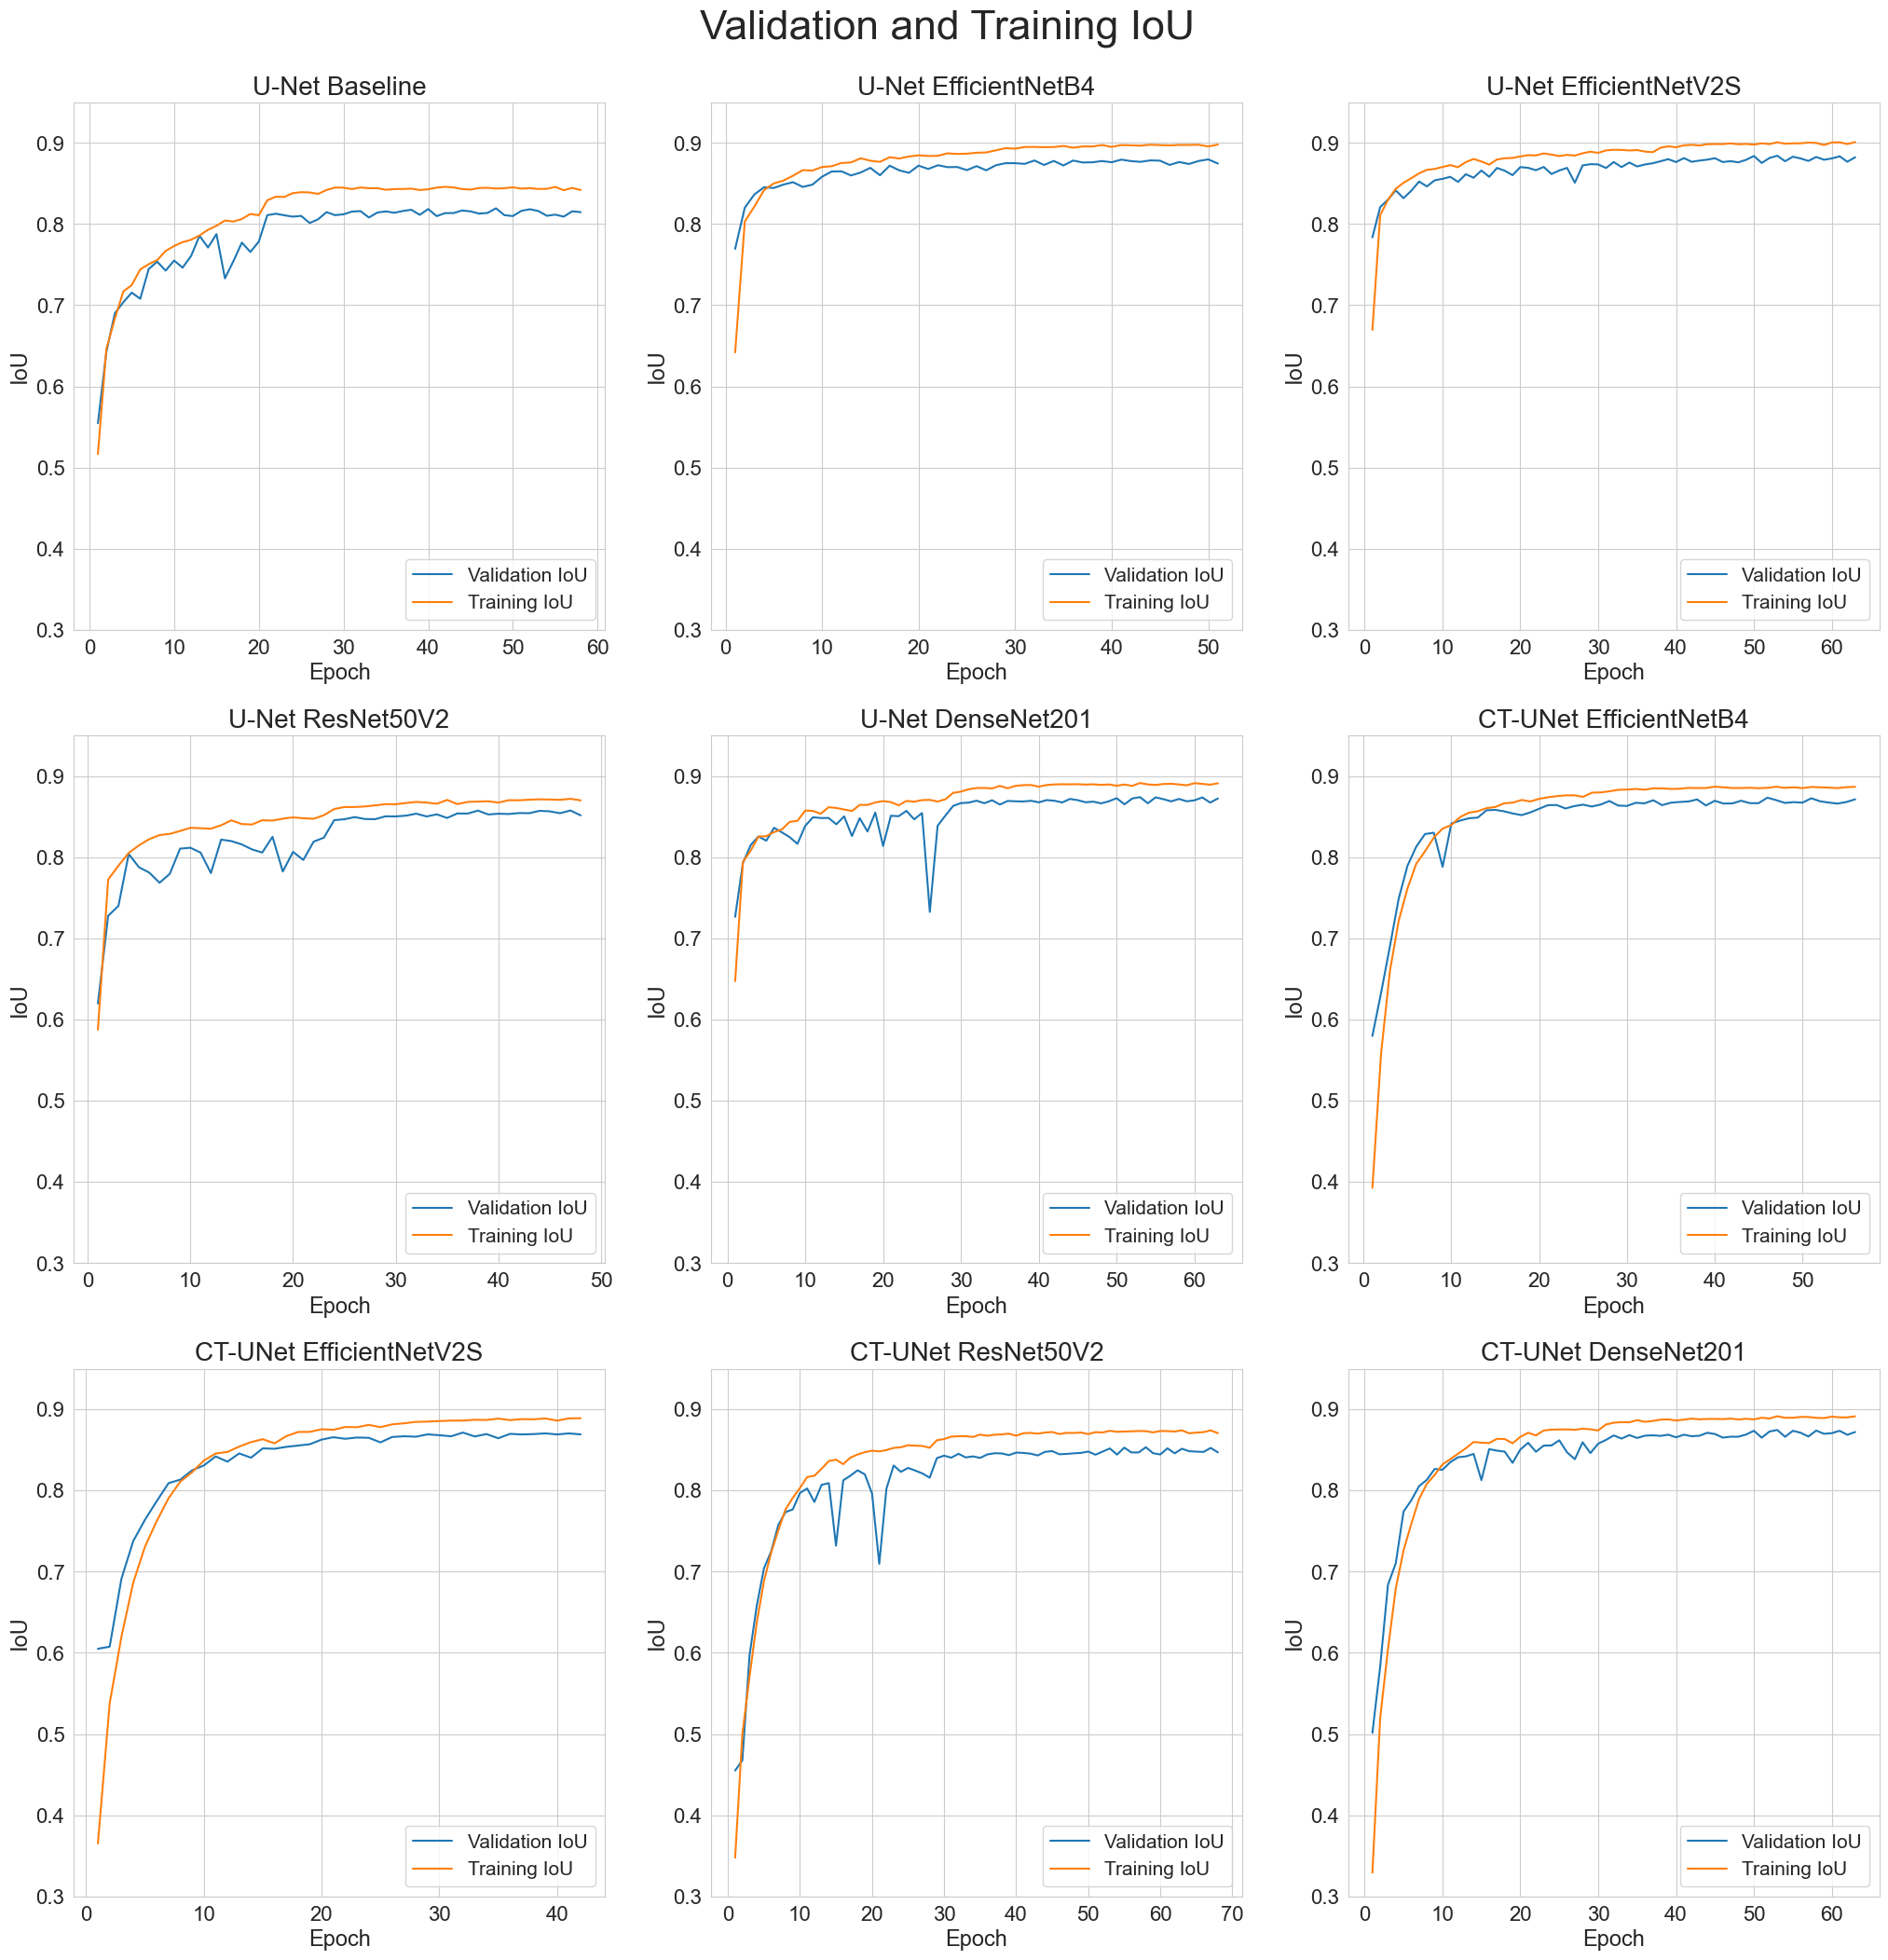

In [50]:
file_names = ['1_UNet_log', '1_UNet_EfficientNetB4_log', '1_UNet_EfficientNetV2S_log', '1_UNet_ResNet50V2_log',
              '1_UNet_DenseNet201_log', '1_CTUNet_EfficientNetB4_Small_log', '1_CTUNet_EfficientNetV2S_Small_log',
              '1_CTUNet_ResNet50V2_Small_log', '1_CTUNet_DenseNet201_Small_log']

train_jaccard, val_jaccard, epoch = export_logs_train(file_names)

plt.figure(figsize=(25, 25))
plt.suptitle("Validation and Training IoU", size=32, y=0.92)

plt.subplot(3, 3, 1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('U-Net Baseline', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[0]], val_jaccard[file_names[0]], label='Validation IoU')
plt.plot(epoch[file_names[0]], train_jaccard[file_names[0]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.subplot(3, 3, 2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('U-Net EfficientNetB4', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[1]], val_jaccard[file_names[1]], label='Validation IoU')
plt.plot(epoch[file_names[1]], train_jaccard[file_names[1]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.subplot(3, 3, 3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('U-Net EfficientNetV2S', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[2]], val_jaccard[file_names[2]], label='Validation IoU')
plt.plot(epoch[file_names[2]], train_jaccard[file_names[2]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.subplot(3, 3, 4)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('U-Net ResNet50V2', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[3]], val_jaccard[file_names[3]], label='Validation IoU')
plt.plot(epoch[file_names[3]], train_jaccard[file_names[3]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.subplot(3, 3, 5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('U-Net DenseNet201', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[4]], val_jaccard[file_names[4]], label='Validation IoU')
plt.plot(epoch[file_names[4]], train_jaccard[file_names[4]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.subplot(3, 3, 6)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('CT-UNet EfficientNetB4', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[5]], val_jaccard[file_names[5]], label='Validation IoU')
plt.plot(epoch[file_names[5]], train_jaccard[file_names[5]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.subplot(3, 3, 7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('CT-UNet EfficientNetV2S', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[6]], val_jaccard[file_names[6]], label='Validation IoU')
plt.plot(epoch[file_names[6]], train_jaccard[file_names[6]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.subplot(3, 3, 8)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('CT-UNet ResNet50V2', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[7]], val_jaccard[file_names[7]], label='Validation IoU')
plt.plot(epoch[file_names[7]], train_jaccard[file_names[7]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.subplot(3, 3, 9)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('CT-UNet DenseNet201', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[8]], val_jaccard[file_names[8]], label='Validation IoU')
plt.plot(epoch[file_names[8]], train_jaccard[file_names[8]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.show()

## Task 2 Training

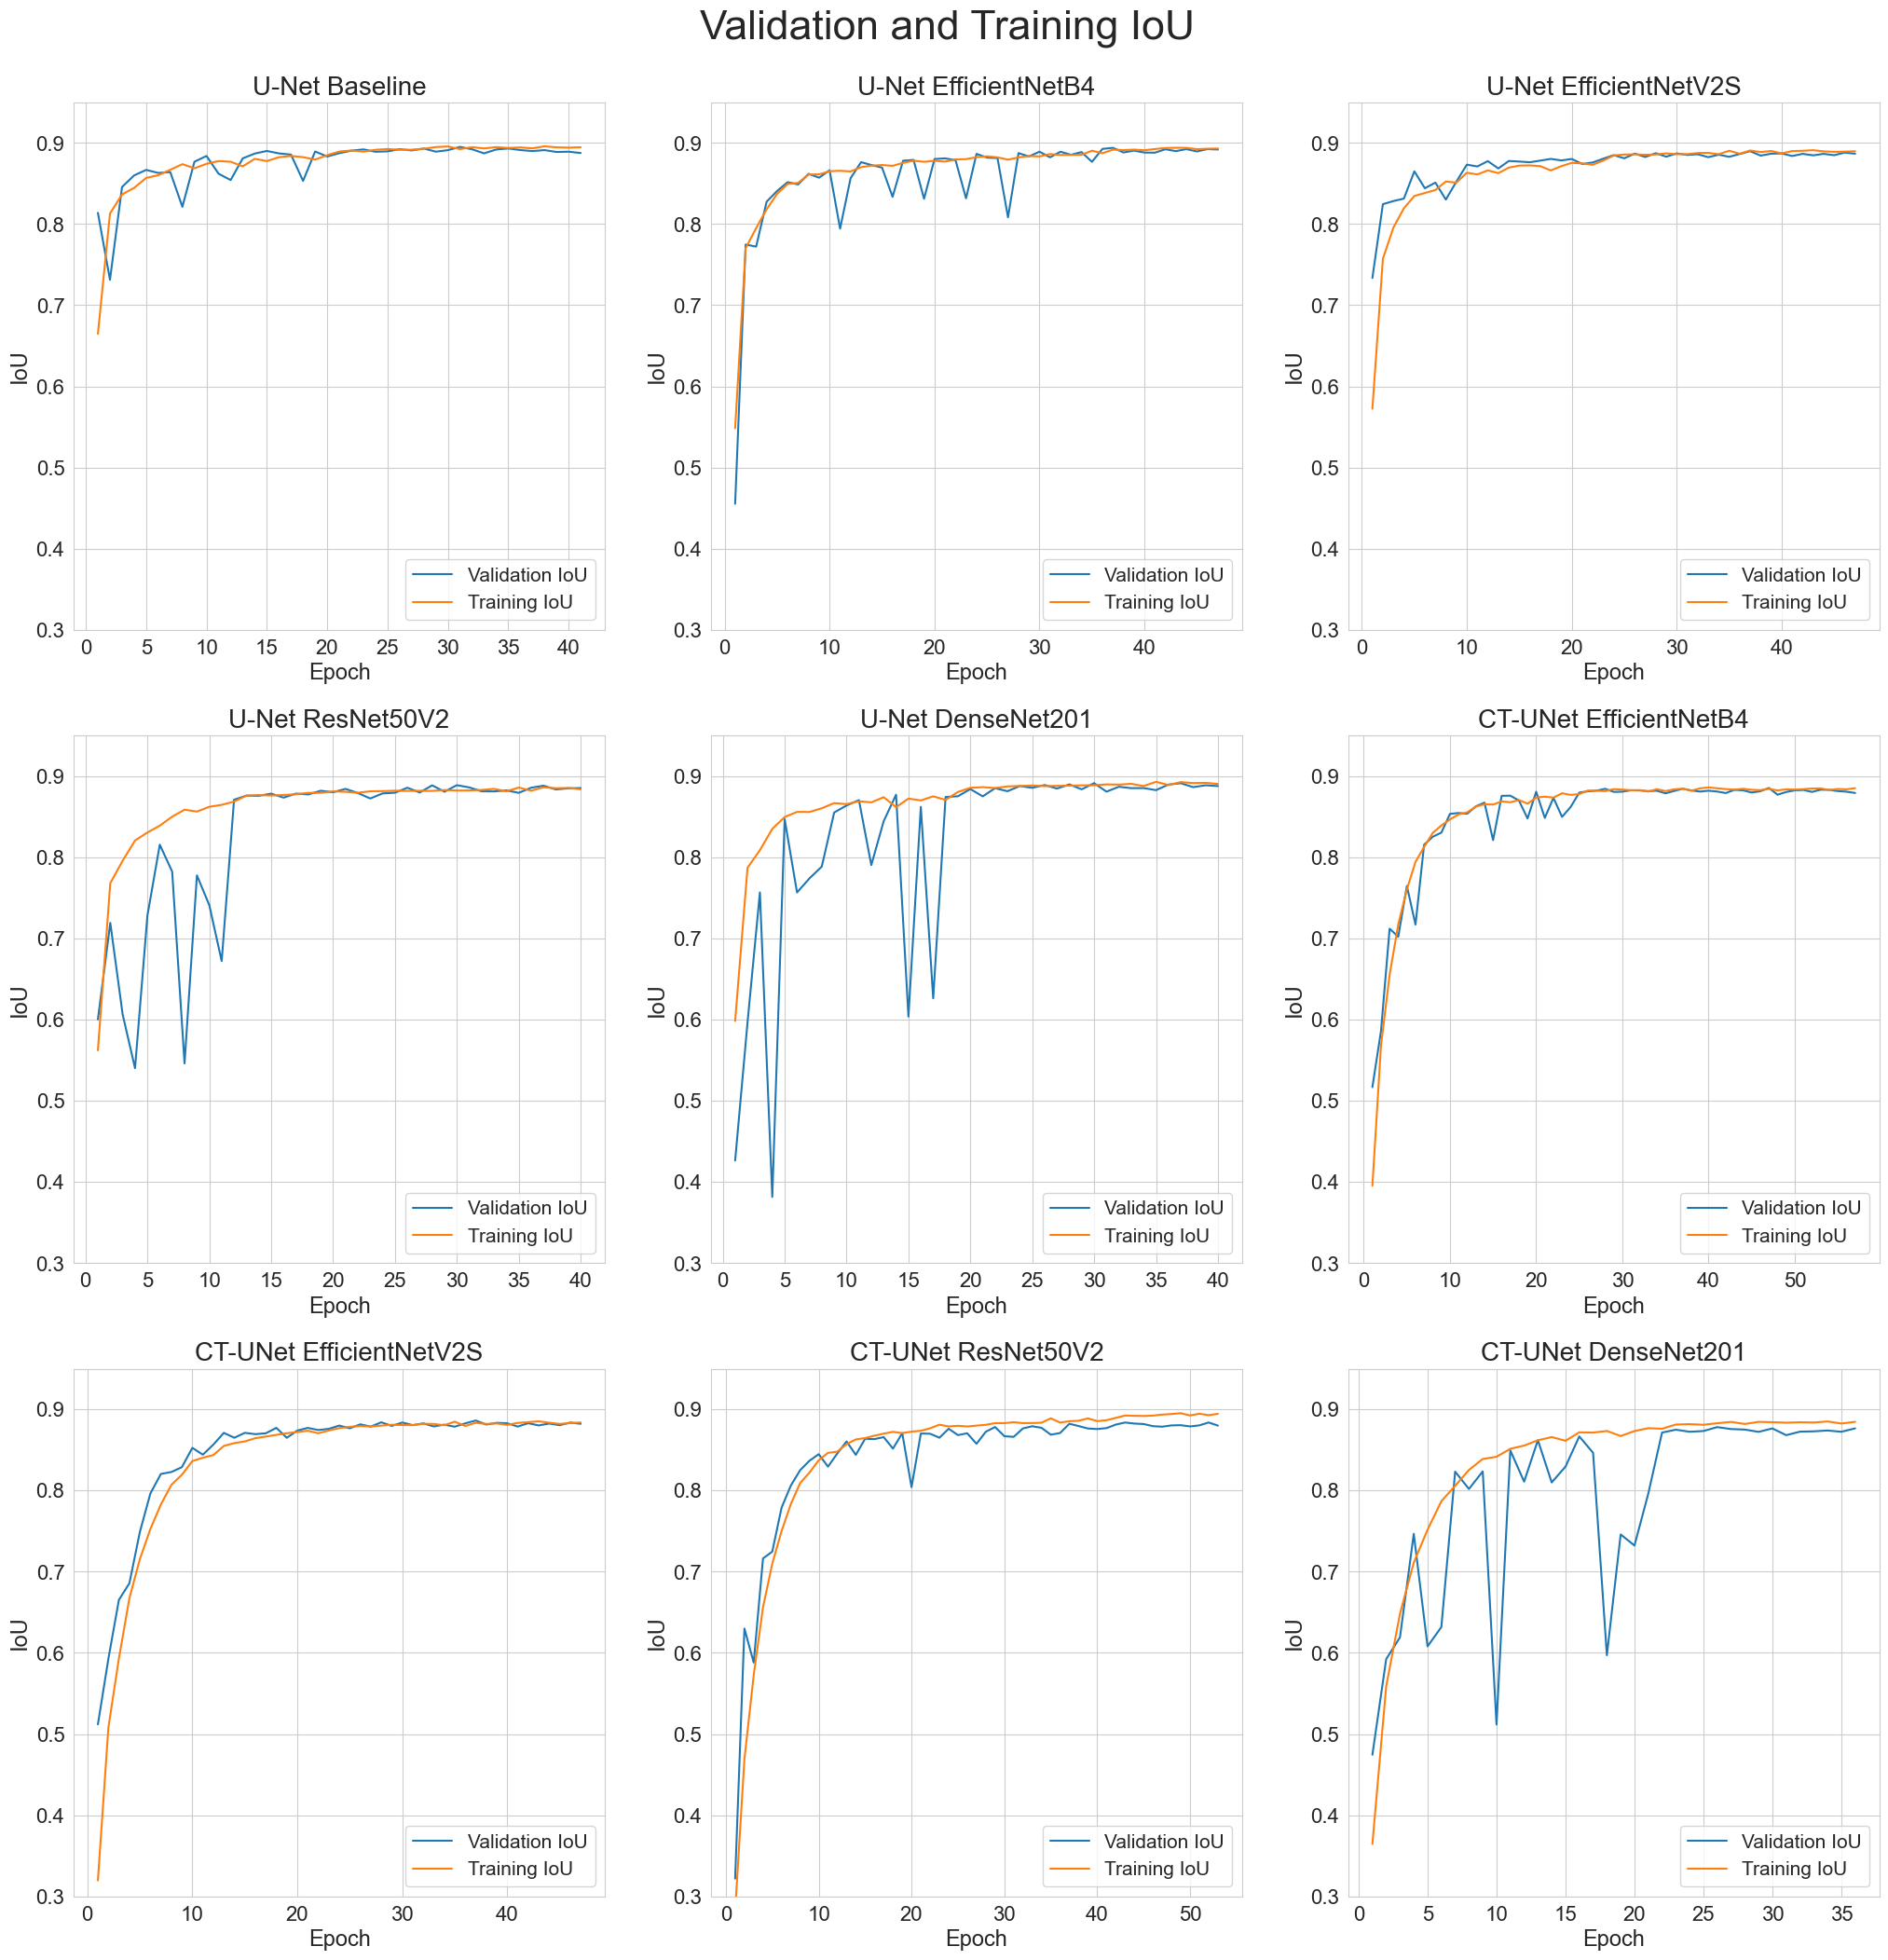

In [51]:
file_names = ['2_UNet_log', '2_UNet_EfficientNetB4_log', '2_UNet_EfficientNetV2S_log', '2_UNet_ResNet50V2_log',
              '2_UNet_DenseNet201_log', '2_CTUNet_EfficientNetB4_log', '2_CTUNet_EfficientNetV2S_log',
              '2_CTUNet_ResNet50V2_log', '2_CTUNet_DenseNet201_log']

train_jaccard, val_jaccard, epoch = export_logs_train(file_names)

plt.figure(figsize=(25, 25))
plt.suptitle("Validation and Training IoU", size=32, y=0.92)

plt.subplot(3, 3, 1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('U-Net Baseline', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[0]], val_jaccard[file_names[0]], label='Validation IoU')
plt.plot(epoch[file_names[0]], train_jaccard[file_names[0]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.subplot(3, 3, 2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('U-Net EfficientNetB4', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[1]], val_jaccard[file_names[1]], label='Validation IoU')
plt.plot(epoch[file_names[1]], train_jaccard[file_names[1]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.subplot(3, 3, 3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('U-Net EfficientNetV2S', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[2]], val_jaccard[file_names[2]], label='Validation IoU')
plt.plot(epoch[file_names[2]], train_jaccard[file_names[2]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.subplot(3, 3, 4)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('U-Net ResNet50V2', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[3]], val_jaccard[file_names[3]], label='Validation IoU')
plt.plot(epoch[file_names[3]], train_jaccard[file_names[3]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.subplot(3, 3, 5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('U-Net DenseNet201', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[4]], val_jaccard[file_names[4]], label='Validation IoU')
plt.plot(epoch[file_names[4]], train_jaccard[file_names[4]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.subplot(3, 3, 6)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('CT-UNet EfficientNetB4', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[5]], val_jaccard[file_names[5]], label='Validation IoU')
plt.plot(epoch[file_names[5]], train_jaccard[file_names[5]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.subplot(3, 3, 7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('CT-UNet EfficientNetV2S', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[6]], val_jaccard[file_names[6]], label='Validation IoU')
plt.plot(epoch[file_names[6]], train_jaccard[file_names[6]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.subplot(3, 3, 8)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('CT-UNet ResNet50V2', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[7]], val_jaccard[file_names[7]], label='Validation IoU')
plt.plot(epoch[file_names[7]], train_jaccard[file_names[7]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.subplot(3, 3, 9)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize="17")
plt.ylabel("IoU", fontsize="17")
plt.title('CT-UNet DenseNet201', fontsize="20")
plt.ylim(0.3, 0.95)
plt.plot(epoch[file_names[8]], val_jaccard[file_names[8]], label='Validation IoU')
plt.plot(epoch[file_names[8]], train_jaccard[file_names[8]], label='Training IoU')
plt.legend(fontsize="15", loc='lower right')

plt.show()

## Task1 Predictions

In [122]:
def compare_pixels(ground_truth, prediction):
    new_img = np.zeros((1, 512, 512, 3), dtype=np.uint8)
    for x in range(len(prediction)):
        for y in range(len(prediction[x])):
            if prediction[x, y] == ground_truth[x, y]:
                if prediction[x, y] == 1:
                    new_img[0, x, y, 0:3] = 255
                else:
                    new_img[0, x, y, 0:3] = 0
            elif prediction[x, y] == 1 and ground_truth[x, y] == 0: #FP
                new_img[0, x, y, 0] = 255
            elif prediction[x, y] == 0 and ground_truth[x, y] == 1: #FN
                new_img[0, x, y, 2] = 255
    return new_img[0]

In [133]:
def plot_predictions(index, X_test, Y_test, Y_pred, Y_pred_tta, Y_pred_ensemble, Y_pred_tta_ensemble):
    plt.figure(figsize=(20,20))
    plt.subplot(161)
    plt.title('Aerial Image')
    plt.axis('off')
    plt.imshow(X_test[index])
    
    plt.subplot(162)
    plt.title('Ground Truth')
    plt.axis('off')
    ground_truth = Y_test[index]
    plt.imshow(ground_truth, cmap='gray')
    
    plt.subplot(163)
    plt.title('Prediction')
    plt.axis('off')
    pred = (Y_pred > 0.5)[index]
    pred = pred.astype(np.uint8)
    pred = compare_pixels(ground_truth, pred)
    plt.imshow(pred, cmap='gray')
    
    plt.subplot(164)
    plt.title('TTA Prediction')
    plt.axis('off')
    pred_tta = (Y_pred_tta > 0.3)
    pred_tta = pred_tta.astype(np.uint8)
    pred_tta = compare_pixels(ground_truth, pred_tta)
    plt.imshow(pred_tta, cmap='gray')
    
    plt.subplot(165)
    plt.title('Ensemble Prediction')
    plt.axis('off')
    pred_ensemble = (Y_pred_ensemble > 0.5)[index]
    pred_ensemble = pred_ensemble.astype(np.uint8)
    pred_ensemble = compare_pixels(ground_truth, pred_ensemble)
    plt.imshow(pred_ensemble, cmap='gray')
    
    plt.subplot(166)
    plt.title('Ensemble TTA Prediction')
    plt.axis('off')
    pred_ensemble_tta = (Y_pred_tta_ensemble > 0.3)
    pred_ensemble_tta = pred_ensemble_tta.astype(np.uint8)
    pred_ensemble_tta = compare_pixels(ground_truth, pred_ensemble_tta)
    plt.imshow(pred_ensemble_tta, cmap='gray')
    
    plt.show()

In [3]:
X_test, Y_test = prepare_test_dataset('1', '1')

X_train size: 1368
Y_train size: 1368


In [4]:
model_name = '1_CTUNet_EfficientNetB4_Small_Checkpoint.h5'
model = models.load_model(os.path.normpath('models/task1/' + model_name), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})
Y_pred = model.predict(X_test[0:450])

15/15 [==============================] - 944s 63s/step


In [5]:
model_name2 = '1_UNet_DenseNet201'
model2 = models.load_model(os.path.normpath('models/task1/' + model_name2), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})
Y_pred2 = model2.predict(X_test[0:450])


15/15 [==============================] - 1995s 135s/step


In [6]:
model_name3 = '1_CTUNet_EfficientNetV2S_Small_Checkpoint.h5'
model3 = models.load_model(os.path.normpath('models/task1/' + model_name3), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})

In [7]:
weights = [0.5, 0.5]
preds = np.array([Y_pred, Y_pred2])
weighted_preds = np.tensordot(preds, weights, axes=(0, 0))

In [128]:
index1 = 57
index2 = 35
index3 = 449

Y_pred_tta1 = tta(model, X_test[index1])
Y_pred_tta2 = tta(model, X_test[index2])
Y_pred_tta3 = tta(model, X_test[index3])

Y_pred2_tta1 = tta(model2, X_test[index1])
Y_pred2_tta2 = tta(model2, X_test[index2])
Y_pred2_tta3 = tta(model2, X_test[index3])

Y_pred3_tta1 = tta(model3, X_test[index1])
Y_pred3_tta2 = tta(model3, X_test[index2])
Y_pred3_tta3 = tta(model3, X_test[index3])

In [129]:
weights = [0.3, 0.4, 0.3]
tta1 = np.array([Y_pred_tta1, Y_pred2_tta1, Y_pred3_tta1])
tta2 = np.array([Y_pred_tta2, Y_pred2_tta2, Y_pred3_tta2])
tta3 = np.array([Y_pred_tta3, Y_pred2_tta3, Y_pred3_tta3])

tta1_w = np.tensordot(tta1, weights, axes=(0, 0))
tta2_w = np.tensordot(tta2, weights, axes=(0, 0))
tta3_w = np.tensordot(tta3, weights, axes=(0, 0))



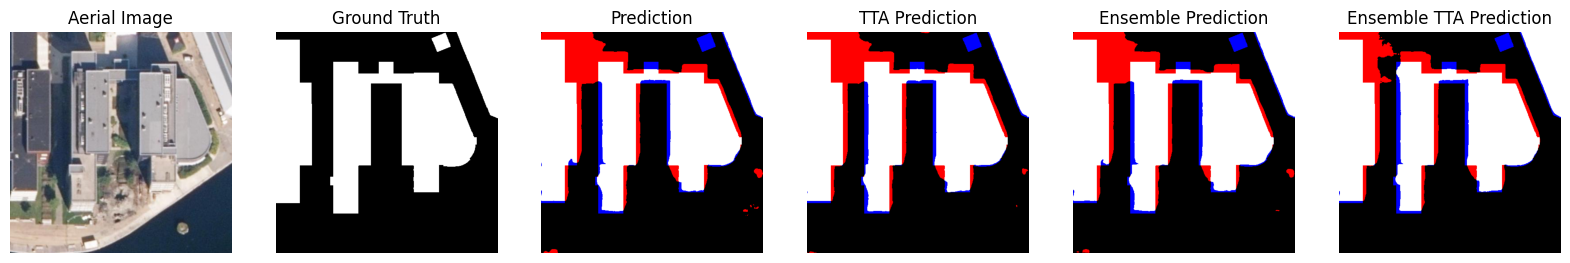

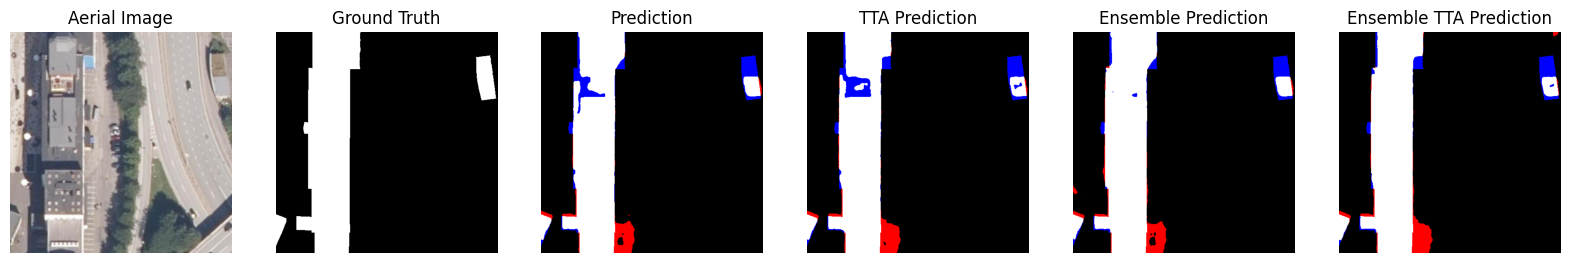

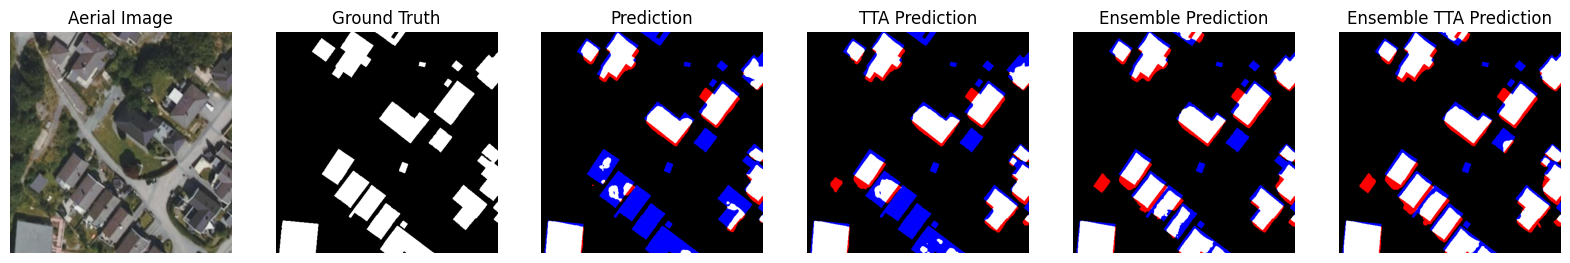

In [134]:
plot_predictions(index1, X_test, Y_test, Y_pred, Y_pred_tta1, weighted_preds, tta1_w)
plot_predictions(index2, X_test, Y_test, Y_pred, Y_pred_tta2, weighted_preds, tta2_w)
plot_predictions(index3, X_test, Y_test, Y_pred, Y_pred_tta3, weighted_preds, tta3_w)

## Task2 Predictions

In [144]:
def plot_predictions(index, X_test, Y_test, Y_pred, Y_pred_tta, Y_pred_ensemble, Y_pred_tta_ensemble):
    plt.figure(figsize=(20,20))
    plt.subplot(171)
    plt.title('Aerial Image')
    plt.axis('off')
    img = X_test[index][:, :, 0:3]
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    
    plt.subplot(172)
    plt.title('Ground Truth')
    plt.axis('off')
    ground_truth = Y_test[index]
    plt.imshow(ground_truth, cmap='gray')
    
    plt.subplot(173)
    plt.title('LiDAR')
    plt.axis('off')
    plt.imshow(X_test[index][:, :, 3], cmap='gray')
    
    plt.subplot(174)
    plt.title('Prediction')
    plt.axis('off')
    pred = (Y_pred > 0.5)[index]
    pred = pred.astype(np.uint8)
    pred = compare_pixels(ground_truth, pred)
    plt.imshow(pred, cmap='gray')
    
    plt.subplot(175)
    plt.title('TTA Prediction')
    plt.axis('off')
    pred_tta = (Y_pred_tta > 0.3)
    pred_tta = pred_tta.astype(np.uint8)
    pred_tta = compare_pixels(ground_truth, pred_tta)
    plt.imshow(pred_tta, cmap='gray')
    
    plt.subplot(176)
    plt.title('Ensemble Prediction')
    plt.axis('off')
    pred_ensemble = (Y_pred_ensemble > 0.5)[index]
    pred_ensemble = pred_ensemble.astype(np.uint8)
    pred_ensemble = compare_pixels(ground_truth, pred_ensemble)
    plt.imshow(pred_ensemble, cmap='gray')
    
    plt.subplot(177)
    plt.title('Ensemble TTA Prediction')
    plt.axis('off')
    pred_ensemble_tta = (Y_pred_tta_ensemble > 0.3)
    pred_ensemble_tta = pred_ensemble_tta.astype(np.uint8)
    pred_ensemble_tta = compare_pixels(ground_truth, pred_ensemble_tta)
    plt.imshow(pred_ensemble_tta, cmap='gray')
    
    plt.show()

In [135]:
X_test, Y_test = prepare_test_dataset('2', '1')

X_train size: 978
Y_train size: 978


In [137]:
model_name = '2_UNet_DenseNet201_Checkpoint.h5'
model = models.load_model(os.path.normpath('models/task2/' + model_name), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})
Y_pred = model.predict(X_test[0:500])

model_name2 = '2_UNet_Checkpoint.h5'
model2 = models.load_model(os.path.normpath('models/task2/' + model_name2), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})
Y_pred2 = model2.predict(X_test[0:500])

model_name3 = '2_CTUNet_EfficientNetV2S'
model3 = models.load_model(os.path.normpath('models/task2/' + model_name3), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})

16/16 [==============================] - 2394s 148s/step


C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\layers\core\lambda_layer.py:324: UserWarning: UNet is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


16/16 [==============================] - 2913s 179s/step


In [138]:
weights = [0.5, 0.5]
preds = np.array([Y_pred, Y_pred2])
weighted_preds = np.tensordot(preds, weights, axes=(0, 0))

In [152]:
index1 = 167
index2 = 400
index3 = 34

Y_pred_tta1 = tta(model, X_test[index1])
Y_pred_tta2 = tta(model, X_test[index2])
Y_pred_tta3 = tta(model, X_test[index3])

Y_pred2_tta1 = tta(model2, X_test[index1])
Y_pred2_tta2 = tta(model2, X_test[index2])
Y_pred2_tta3 = tta(model2, X_test[index3])

Y_pred3_tta1 = tta(model3, X_test[index1])
Y_pred3_tta2 = tta(model3, X_test[index2])
Y_pred3_tta3 = tta(model3, X_test[index3])

In [153]:
weights = [0.3, 0.5, 0.2]
tta1 = np.array([Y_pred_tta1, Y_pred2_tta1, Y_pred3_tta1])
tta2 = np.array([Y_pred_tta2, Y_pred2_tta2, Y_pred3_tta2])
tta3 = np.array([Y_pred_tta3, Y_pred2_tta3, Y_pred3_tta3])

tta1_w = np.tensordot(tta1, weights, axes=(0, 0))
tta2_w = np.tensordot(tta2, weights, axes=(0, 0))
tta3_w = np.tensordot(tta3, weights, axes=(0, 0))

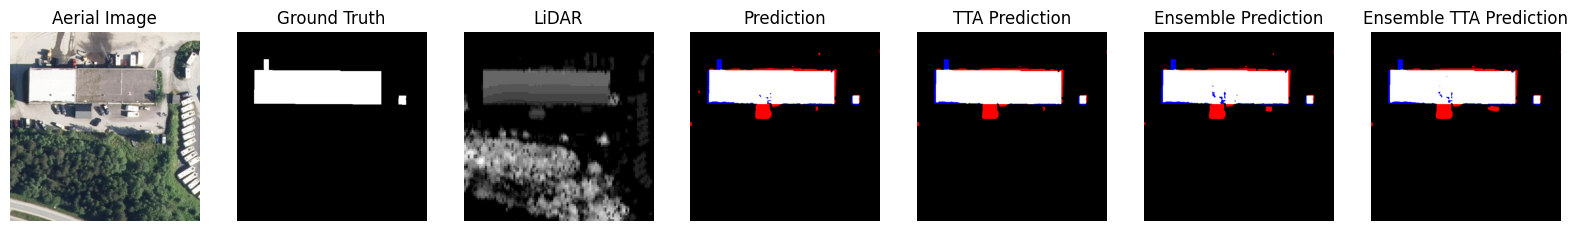

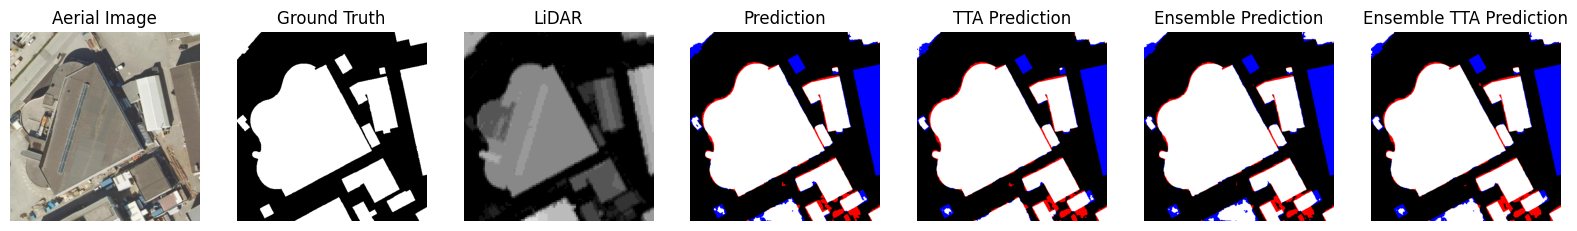

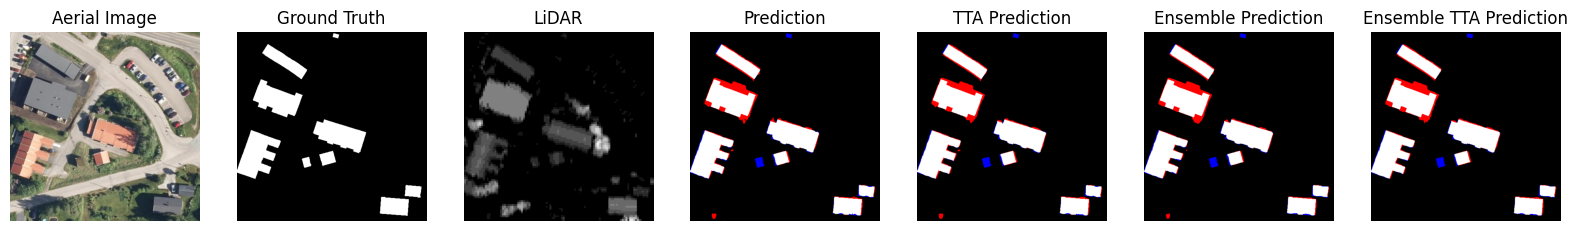

In [154]:
plot_predictions(index1, X_test, Y_test, Y_pred, Y_pred_tta1, weighted_preds, tta1_w)
plot_predictions(index2, X_test, Y_test, Y_pred, Y_pred_tta2, weighted_preds, tta2_w)
plot_predictions(index3, X_test, Y_test, Y_pred, Y_pred_tta3, weighted_preds, tta3_w)

## LiDAR vs Non-LiDAR

In [199]:
def plot_predictions(index, X_test, Y_test, rgbpred, lidarpred):
    plt.figure(figsize=(20,20))
    
    plt.subplot(151)
    plt.title('Aerial Image')
    plt.axis('off')
    img = X_test[index][:, :, 0:3]
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    
    plt.subplot(152)
    plt.title('LiDAR')
    plt.axis('off')
    plt.imshow(X_test[index][:, :, 3], cmap='gray')
    
    plt.subplot(153)
    plt.title('Ground Truth')
    plt.axis('off')
    gt = cv.cvtColor(Y_test[index]*255, cv.COLOR_BGR2RGB)
    plt.imshow(gt)
    
    ground_truth = Y_test[index]
    plt.subplot(154)
    plt.title('Task 1 Prediction')
    plt.axis('off')
    rgbp = (rgbpred > 0.3).astype(np.uint8)
    rgbp_c = compare_pixels(ground_truth, rgbp)
    plt.imshow(rgbp_c, cmap='gray')
    
    plt.subplot(155)
    plt.title('Task 2 Prediction')
    plt.axis('off')
    lidarp = (lidarpred > 0.3).astype(np.uint8)
    lidarp_c = compare_pixels(ground_truth, lidarp)
    plt.imshow(lidarp_c, cmap='gray')
    
    
    plt.show()

In [155]:
X_test1, Y_test1 = prepare_test_dataset('1', '2')
X_test2, Y_test2 = prepare_test_dataset('2', '2')

X_train size: 1500
Y_train size: 1500
X_train size: 1500
Y_train size: 1500


In [160]:
model_name = '1_CTUNet_EfficientNetB4_Small_Checkpoint.h5'
model1_1 = models.load_model(os.path.normpath('models/task1/' + model_name), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})

model_name2 = '1_UNet_DenseNet201'
model2_1 = models.load_model(os.path.normpath('models/task1/' + model_name2), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})

model_name3 = '1_CTUNet_EfficientNetV2S_Small_Checkpoint.h5'
model3_1 = models.load_model(os.path.normpath('models/task1/' + model_name3), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})

weights1 = [0.3, 0.4, 0.3]

In [161]:
model_name = '2_UNet_DenseNet201_Checkpoint.h5'
model1_2 = models.load_model(os.path.normpath('models/task2/' + model_name), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})

model_name2 = '2_UNet_Checkpoint.h5'
model2_2 = models.load_model(os.path.normpath('models/task2/' + model_name2), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})

model_name3 = '2_CTUNet_EfficientNetV2S'
model3_2 = models.load_model(os.path.normpath('models/task2/' + model_name3), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})

weights2 = [0.3, 0.5, 0.2]

C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\layers\core\lambda_layer.py:324: UserWarning: UNet is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


In [201]:
index1 = 1080
index2 = 757
index3 = 758

In [202]:
#RGB
Y_pred_tta1 = tta(model1_1, X_test1[index1])
Y_pred_tta2 = tta(model1_1, X_test1[index2])
Y_pred_tta3 = tta(model1_1, X_test1[index3])

Y_pred2_tta1 = tta(model2_1, X_test1[index1])
Y_pred2_tta2 = tta(model2_1, X_test1[index2])
Y_pred2_tta3 = tta(model2_1, X_test1[index3])

Y_pred3_tta1 = tta(model3_1, X_test1[index1])
Y_pred3_tta2 = tta(model3_1, X_test1[index2])
Y_pred3_tta3 = tta(model3_1, X_test1[index3])

tta1 = np.array([Y_pred_tta1, Y_pred2_tta1, Y_pred3_tta1])
tta2 = np.array([Y_pred_tta2, Y_pred2_tta2, Y_pred3_tta2])
tta3 = np.array([Y_pred_tta3, Y_pred2_tta3, Y_pred3_tta3])

tta1_w_1 = np.tensordot(tta1, weights1, axes=(0, 0))
tta2_w_1 = np.tensordot(tta2, weights1, axes=(0, 0))
tta3_w_1 = np.tensordot(tta3, weights1, axes=(0, 0))

In [203]:
#RGB+LiDAR
Y_pred_tta1 = tta(model1_2, X_test2[index1])
Y_pred_tta2 = tta(model1_2, X_test2[index2])
Y_pred_tta3 = tta(model1_2, X_test2[index3])

Y_pred2_tta1 = tta(model2_2, X_test2[index1])
Y_pred2_tta2 = tta(model2_2, X_test2[index2])
Y_pred2_tta3 = tta(model2_2, X_test2[index3])

Y_pred3_tta1 = tta(model3_2, X_test2[index1])
Y_pred3_tta2 = tta(model3_2, X_test2[index2])
Y_pred3_tta3 = tta(model3_2, X_test2[index3])

tta1 = np.array([Y_pred_tta1, Y_pred2_tta1, Y_pred3_tta1])
tta2 = np.array([Y_pred_tta2, Y_pred2_tta2, Y_pred3_tta2])
tta3 = np.array([Y_pred_tta3, Y_pred2_tta3, Y_pred3_tta3])

tta1_w_2 = np.tensordot(tta1, weights2, axes=(0, 0))
tta2_w_2 = np.tensordot(tta2, weights2, axes=(0, 0))
tta3_w_2 = np.tensordot(tta3, weights2, axes=(0, 0))

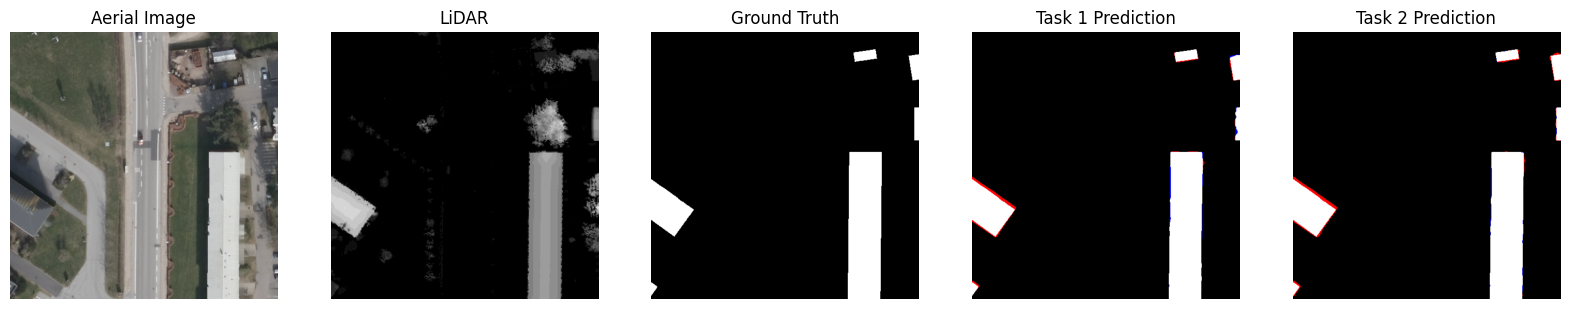

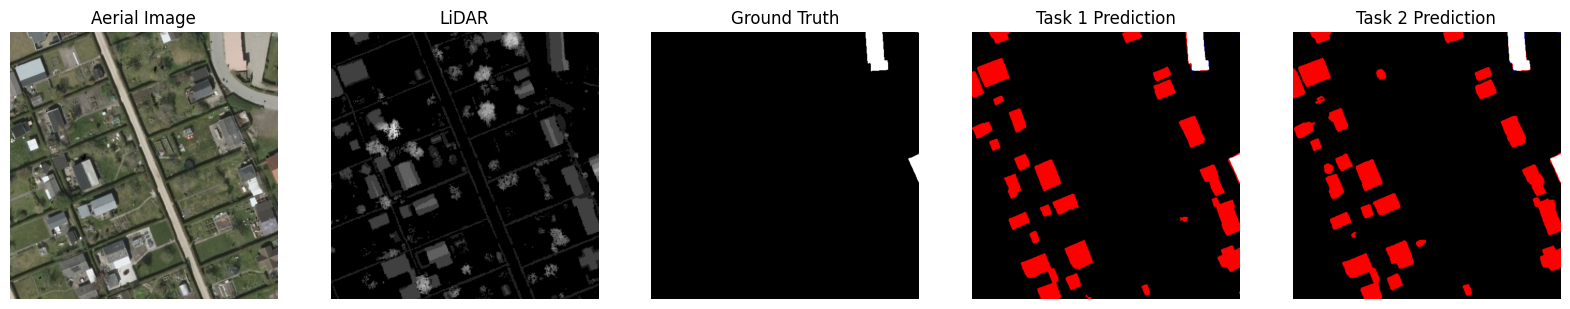

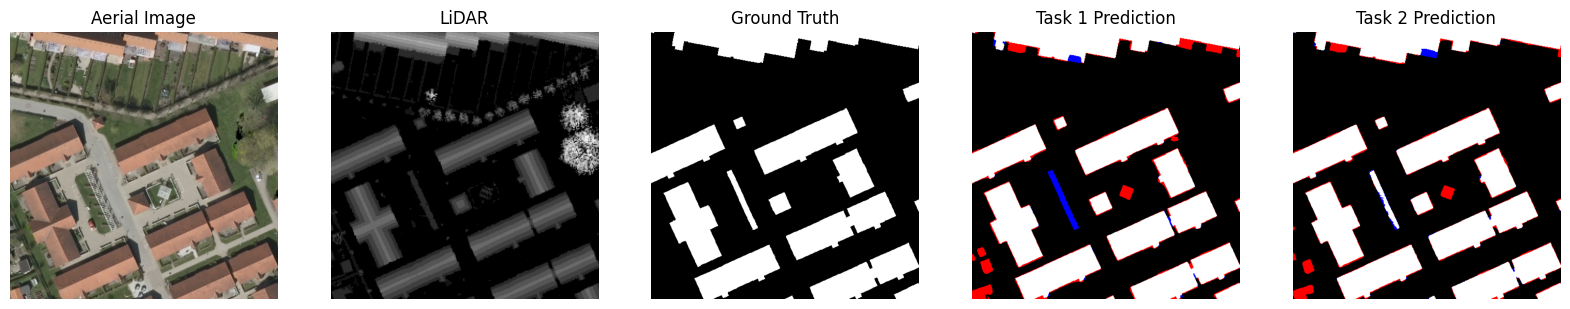

In [204]:
plot_predictions(index1, X_test2, Y_test1, tta1_w_1, tta1_w_2)
plot_predictions(index2, X_test2, Y_test1, tta2_w_1, tta2_w_2)
plot_predictions(index3, X_test2, Y_test1, tta3_w_1, tta3_w_2)
